# Prediction example

This example will show you the process of prediction and analysis.

Because pred_cleaning and pred_preprocessing need raw data, so "example" folder has given you the output data.

> model.pt -> model after training (model class and setting included in code)

> true.npy -> output of pred_cleaning

> test_all.npy -> output of pred_preprocessing of data, which has 10000 sequence data and slide_num = 5

> label_all.npy -> output of pred_preprocessing of label

If you didn't download the folder, must execute these two cells.

In [ ]:
!git clone https://github.com/YiChingLLin/Dinkle.git

Cloning into 'Dinkle'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 206 (delta 118), reused 146 (delta 61), pack-reused 0
Receiving objects: 100% (206/206), 7.74 MiB | 3.97 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
cd ./Dinkle/example/

/content/Dinkle/example


Start from here

In [ ]:
import pandas as pd
import numpy as np
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

# # below is for loading data from google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

sequence_num = 100
partNo = "0162B00100" #料號編號
print("Sequence number: ", sequence_num)

# put your folder path, ex: '/content/drive/MyDrive/.../'
folder_path = './'

# put model name, ex: 'model.pt' for model path
model_path = folder_path + 'model.pt'

Sequence number:  100


#Load model
Model class and setting for load model.
If you testing after training model, you can pass.

In [ ]:
"""
model class, should cpoy from training model
"""
class BiLSTM_layer(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, bidirectional, batch_first=False):
      super(BiLSTM_layer, self).__init__()
      self.lstm = nn.LSTM(
          input_size=input_size,
          hidden_size=hidden_size,
          num_layers=num_layers,
          bidirectional=bidirectional,
          batch_first=batch_first
      )

      self.fc = nn.Linear(hidden_size, 26)
      

  def forward(self, inputs):
      out, (h_n, c_n) = self.lstm(inputs, None)
      outputs = self.fc(torch.mean(h_n.squeeze(0), dim=0))

      return outputs

class DataEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(DataEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                              nn.ReLU(),
                              nn.Dropout(dropout),
                              nn.Linear(hidden_dim, output_dim)
                            )
  def forward(self, x):
    return self.net(x)

class minmax_RuleEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(minmax_RuleEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(hidden_dim, output_dim)
                            )

  def forward(self, x):
    return self.net(x)
    

class outbound_RuleEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(outbound_RuleEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(hidden_dim, output_dim)
                            )

  def forward(self, x):
    return self.net(x)
    
class DataonlyNet(nn.Module):
  def __init__(self, input_dim, output_dim, data_encoder, hidden_dim=4, n_layers=2, skip=False, input_type='state'):
    super(DataonlyNet, self).__init__()
    self.skip = skip
    self.input_type = input_type
    self.data_encoder = data_encoder
    self.n_layers = n_layers
    self.input_dim_decision_block = self.data_encoder.output_dim

    self.net = []
    for i in range(n_layers):
      if i == 0:
        in_dim = self.input_dim_decision_block
      else:
        in_dim = hidden_dim

      if i == n_layers-1:
        out_dim = output_dim
      else:
        out_dim = hidden_dim

      #self.net.append(nn.Linear(in_dim, out_dim))
      
      self.net.append(BiLSTM_layer(
              input_size=in_dim,
              hidden_size=64,
              num_layers=1,
              bidirectional=True,
              batch_first=True
          ))
      
      # self.net.append(nn.Flatten())
      # self.net.append(nn.Linear(64, 26))
      '''
      if i != n_layers-1:
        self.net.append(nn.ReLU())
      '''
      
    #self.net.append(nn.ReLU())
    self.net = nn.Sequential(*self.net)

  def get_z(self, x, alpha=0.0):
    data_z = self.data_encoder(x)

    return data_z

  def forward(self, x, alpha=0.0):    
      data_z = self.data_encoder(x)
      z=data_z
      if self.skip:
        if self.input_type == 'seq':
          return self.net(z) + x[:,-1,:]
        else:
          return self.net(z) + x    
      else:
        return self.net(z) 

class Net(nn.Module):
  def __init__(self, input_dim, output_dim, minmax_rule_encoder, outbound_rule_encoder, data_encoder, hidden_dim=3, n_layers=1, merge='cat', skip=False, input_type='state'):
    super(Net, self).__init__()
    self.skip = skip
    self.input_type = input_type
    self.minmax_rule_encoder = minmax_rule_encoder
    self.outbound_rule_encoder = outbound_rule_encoder
    self.data_encoder = data_encoder
    self.n_layers = n_layers
    assert self.minmax_rule_encoder.input_dim ==  self.data_encoder.input_dim
    assert self.minmax_rule_encoder.output_dim ==  self.data_encoder.output_dim
    self.merge = merge
    if merge == 'cat':
      self.input_dim_decision_block = self.minmax_rule_encoder.output_dim * 3
    elif merge == 'add':
      self.input_dim_decision_block = self.minmax_rule_encoder.output_dim

    self.net = []
    for i in range(n_layers):
      if i == 0:
        in_dim = self.input_dim_decision_block
      else:
        in_dim = hidden_dim

      if i == n_layers-1:
        out_dim = output_dim
      else:
        out_dim = hidden_dim

      #self.net.append(nn.Linear(in_dim, out_dim))
      
      self.net.append(BiLSTM_layer(
              input_size=in_dim,
              hidden_size=64,
              num_layers=1,
              bidirectional=True,
              batch_first=True
          ))
      
      # self.net.append(nn.Flatten())
      # self.net.append(nn.Linear(64, 26))
     
      
    #self.net.append(nn.ReLU())
    self.net = nn.Sequential(*self.net)

  def get_z(self, x, alpha=0.1, beta=0.1):
    minmax_rule_z = self.minmax_rule_encoder(x)
    outbound_rule_z = self.outbound_rule_encoder(x)
    data_z = self.data_encoder(x)

    if self.merge=='add':
      z = alpha*minmax_rule_z + beta*outbound_rule_z + (1-alpha-beta)*data_z    # merge: Add
    elif self.merge=='cat':
      z = torch.cat((alpha*minmax_rule_z , beta*outbound_rule_z , (1-alpha-beta)*data_z), dim=-1)    # merge: Concat
    elif self.merge=='equal_cat':
      z = torch.cat((minmax_rule_z,outbound_rule_z, data_z), dim=-1)    # merge: Concat

    return z

  def forward(self, x, alpha=0.1, beta=0.1):
      # merge: cat or add
      minmax_rule_z = self.minmax_rule_encoder(x)
      outbound_rule_z = self.outbound_rule_encoder(x)
      data_z = self.data_encoder(x)

      if self.merge=='add':
        z = alpha*minmax_rule_z + beta*outbound_rule_z + (1-alpha-beta)*data_z    # merge: Add
      elif self.merge=='cat':
        z = torch.cat((alpha*minmax_rule_z , beta*outbound_rule_z , (1-alpha-beta)*data_z), dim=-1)    # merge: Concat
      elif self.merge=='equal_cat':
        z = torch.cat((minmax_rule_z, outbound_rule_z, data_z), dim=-1)    # merge: Concat
      else:
        print(self.merge)
      
      # z = torch.flatten(z, start_dim=1)

      if self.skip:
        if self.input_type == 'seq':
          return self.net(z) + x[:,-1,:]
        else:
          return self.net(z) + x    
      else:
        return self.net(z) 
        
        try:
          return self.net(z)   
        except:
          print(type(z))
          print(z.shape)

In [ ]:
"""
model setting, should cpoy from training model
"""
merge = 'cat'

input_dim = 3
input_dim_encoder = 3
output_dim_encoder = 2
hidden_dim_encoder = 64
hidden_dim_db = 64
output_dim_encoder = output_dim_encoder
hidden_dim_encoder = hidden_dim_encoder
hidden_dim_db = hidden_dim_db
output_dim = 26
n_layers = 1
use_type=''


outbound_rule_encoder = outbound_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.3)
minmax_rule_encoder = minmax_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.3)
data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.3)

if use_type=='no_rule':
  model = Net(input_dim, output_dim, minmax_rule_encoder, outbound_rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge)
else:
  model =DataonlyNet (input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers)

In [ ]:
"""
Load model
"""
model = torch.load(model_path)
model.eval()

Net(
  (minmax_rule_encoder): minmax_RuleEncoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (outbound_rule_encoder): outbound_RuleEncoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (data_encoder): DataEncoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (net): Sequential(
    (0): BiLSTM_layer(
      (lstm): LSTM(6, 64, batch_first=True, bidirectional=True)
      (fc): Linear(in_features=64, out_features=26, bias=True)
    )
  )
)

#Prediction

In [ ]:
"""
規格判斷, data為預測結果, partNo為料號
"""
def measure_std(data, partNo):
  measure = []
  for data_num in range(len(data)):
    partNo = partNo
    if partNo == "0162B00100":
      max_std = [3.35, 2.30, 6.30, 2.77, 2.30, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B00200":
      max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B00200-1":
      max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
      min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

    elif partNo == "0162B01100":
      max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B01100-1":
      max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
      min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

    else:
      return "Error"

    wrong = False
    for detail_num in range(13):
      if data[data_num][detail_num] > max_std[detail_num] or data[data_num][detail_num] < min_std[detail_num]:
        wrong = True
      
      if data[data_num][detail_num+13] > max_std[detail_num] or data[data_num][detail_num+13] < min_std[detail_num]: 
        wrong = True

    if wrong == True:
      measure.append(0) # notok
    else:
      measure.append(1) # ok

  return measure

In [ ]:
"""
計算預測準確率, 預測準確率 = 預測良品 / 總筆數
"""
def rate(data):
  num = len(data)
  good_num = np.sum(data["measure_pred"])
  good_rate = good_num/num
  print(str(good_num)+"/"+str(num)+" 良率: "+str(good_rate))

In [ ]:
"""
若以特定機台工單號/特定機台做預測, 圖片下標label呈現
特定機台工單號：日期時間
特定機台：日期時間_工單號
"""
def pred_label(pkg=False, machine=False):
  if pkg: #特定機台工單號
    for i in range(0, len(label), int(len(label)/10)):
      label_i = str(label[i])
      labels.append(label_i[2:15]) #日期時間

  if machine:  #特定機台
    for i in range(0, len(label), int(len(label)/10)):
      label_i = str(label[i])
      labels.append(label_i[2:15]+label_i[21:31]) #日期時間_工單號

In [ ]:
"""
各detail預測結果以圖片呈現
水平線：max標準、min標準
折線圖：預測max、預測min、預測avg((max+min)/2)
散布點：實際瞬測儀抽測數據

橫軸：時間
縱軸：預測值
"""
def pred_detail_plot(partNo, pkg=False, machine=False):
  partNo = partNo
  if partNo == "0162B00100":
    max_std = [3.35, 2.30, 6.30, 2.77, 2.30, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63]
    min_std = [3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53]

  elif partNo == "0162B00200":
    max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
    min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

  elif partNo == "0162B00200-1":
    max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
    min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

  elif partNo == "0162B01100":
    max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
    min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

  elif partNo == "0162B01100-1":
    max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
    min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

  for i in range(1,14):
    print("detail"+str(i))
    len_pred = len(pred)
    plt.figure(figsize=(40,10))

    plt.plot(df['pred'+str(i)], color = 'g', label="max", linewidth=0.25)
    plt.plot(df['pred'+str(i+13)], color = 'c', label="min", linewidth=0.25)
    plt.plot((df['pred'+str(i)]+df['pred'+str(i+13)])/2, color = 'm', label="max_min_avg", linewidth=0.25)

    plt.plot(np.full(len_pred, max_std[i-1]), color = 'r', label="std max")
    plt.plot(np.full(len_pred, min_std[i-1]), color = 'b', label="std min")

    plt.scatter(data_df["num"], data_df['true'+str(i)], s=1)
    
    plt.legend(loc = "best", fontsize=8)
    #下標label
    if pkg:
      plt.xticks(range(0, len_pred, int(len(label)/10)), labels)
    if machine:
      plt.xticks(range(0, len_pred, int(len(label)/10)), labels)

    plt.title("detail"+str(i))
    # plt.savefig(folder_path+"pred_detail"+str(i)+".jpg")
    plt.show()

In [ ]:
"""
各detail預測結果之平均以圖片呈現
水平線：max標準、min標準
折線圖：預測avg((max+min)/2)
散布點：實際瞬測儀抽測數據

橫軸：時間
縱軸：預測值
"""
def pred_avg_plot(partNo, pkg=False, machine=False):
  partNo = partNo
  if partNo == "0162B00100":
    max_std = [3.35, 2.30, 6.30, 2.77, 2.30, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63]
    min_std = [3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53]

  elif partNo == "0162B00200":
    max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
    min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

  elif partNo == "0162B00200-1":
    max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
    min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

  elif partNo == "0162B01100":
    max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
    min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

  elif partNo == "0162B01100-1":
    max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
    min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

  for i in range(1,14):
    print("detail"+str(i))
    len_pred = len(pred)
    plt.figure(figsize=(40,10))

    plt.plot((df['pred'+str(i)]+df['pred'+str(i+13)])/2, color = 'm', label="max_min_avg", linewidth=0.25)

    plt.plot(np.full(len_pred, max_std[i-1]), color = 'r', label="std max")
    plt.plot(np.full(len_pred, min_std[i-1]), color = 'b', label="std min")

    plt.scatter(data_df["num"], data_df['true'+str(i)], s=1)
    
    plt.legend(loc = "best", fontsize=8)
    #下標label
    if pkg:
      plt.xticks(range(0, len_pred, int(len(label)/10)), labels)
    if machine:
      plt.xticks(range(0, len_pred, int(len(label)/10)), labels)

    plt.title("detail"+str(i))
    # plt.savefig(folder_path+"pred_avg_detail"+str(i)+".jpg")
    plt.show()

#Prediction - All

In [ ]:
by_package = False #若預測資料為特定機台工單號為True
by_machine = False #若預測資料為特定機台為True

# put test data and label npy file path, ex: 'test_all.npy', 'label_all.npy'
test = np.load(folder_path + 'test_all.npy')
label = np.load(folder_path + 'label_all.npy', allow_pickle=True)
print(test.shape)  #(data_num, sequence_num, feature_num)
print(label.shape) #(data_num, 1)

test = torch.tensor(test).to(torch.float32)
test = test[:1000]   #若只要跑前1000筆
label = label[:1000] #若只要跑前1000筆
print(test.shape)

(21564, 100, 3)
(21564, 1)
torch.Size([1000, 100, 3])


In [ ]:
"""
prediction, and save to pred.npy
"""
with torch.no_grad():
  pred = model(test, alpha=0.1, beta=0.1)

np.save(folder_path + 'pred.npy', pred)

In [ ]:
"""
將所有資料以dataframe形式存入csv中
欄位0~299為data, pred+編號 為預測值, label為序列起始沖壓機編號, measure_pred為預測良品/不良品
"""
df = pd.DataFrame(test.reshape(-1, sequence_num*3).numpy())
p_df = pd.DataFrame(pred.numpy())

for i in range(26):
  df['pred'+str(i+1)] = p_df[i]

measure_pred = np.array(measure_std(pred, partNo))

df['label'] = label
df['measure_pred'] = measure_pred

# 真實抽測資料
data = np.load(folder_path+'true.npy',allow_pickle=True)
data = pd.DataFrame(data)
data_true = []
data_label = []
data_df = pd.DataFrame()

# 比對真實抽測點對應之位置, 此部分耗時
for pred_num in range(len(pred)):
  for data_num in range(len(data)):
    if data[0][data_num] == label[pred_num]: 
      data_label.append(pred_num)
      true = []
      for i in range(13):
        true.append(data.iloc[data_num][i+1])
      data_true.append(true)

data_df["num"] = pd.DataFrame(data_label)
data_true = pd.DataFrame(data_true)
for i in range(13):
  data_df['true'+str(i+1)] = data_true[i]

df.to_csv(folder_path +"/test.csv", header=True, index=True) 
print(df.head(10))      #輸入資料、預測結果、序列起始沖壓機編號、預測良品/不良品
print(data_df.head(10)) #真實抽測點對應之序列及抽測數據

       0    1         2      3    4         5      6    7         8      9  \
0  314.0  1.0  1.633333  299.0  2.0  1.183333  299.0  2.0  4.983333  299.0   
1  299.0  2.0  4.683333  299.0  2.0  4.983333  299.0  2.0  4.950000  299.0   
2  299.0  2.0  4.983333  299.0  2.0  5.000000  299.0  2.0  4.966667  299.0   
3  299.0  2.0  4.966667  299.0  2.0  4.983333  299.0  2.0  1.383333  299.0   
4  299.0  2.0  0.533333  299.0  2.0  4.983333  299.0  2.0  4.983333  299.0   
5  299.0  2.0  0.350000  314.0  1.0  2.716667  299.0  2.0  2.450000  299.0   
6  299.0  2.0  4.966667  299.0  2.0  4.983333  299.0  2.0  5.016667  299.0   
7  299.0  2.0  4.983333  299.0  2.0  5.000000  314.0  1.0  2.433333  299.0   
8  299.0  2.0  4.816667  299.0  2.0  4.983333  299.0  2.0  4.983333  299.0   
9  299.0  2.0  4.983333  299.0  2.0  4.966667  299.0  2.0  5.000000  314.0   

   ...    pred19    pred20    pred21    pred22    pred23    pred24    pred25  \
0  ...  3.331318  2.374215  0.400302  0.558845  0.573610  0.5

987/1000 良率: 0.987
detail1


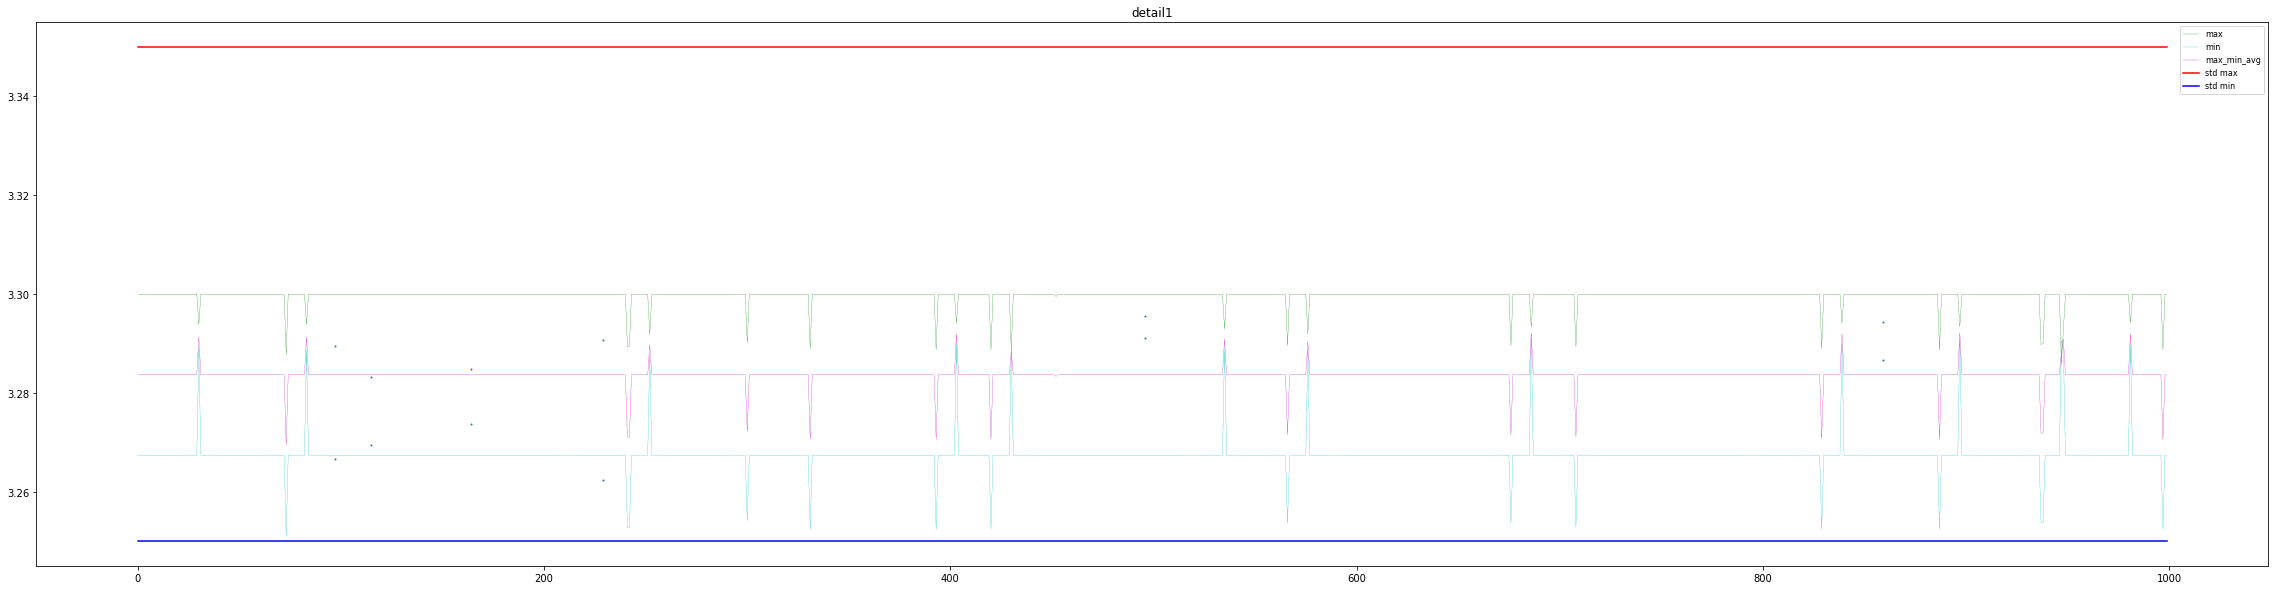

detail2


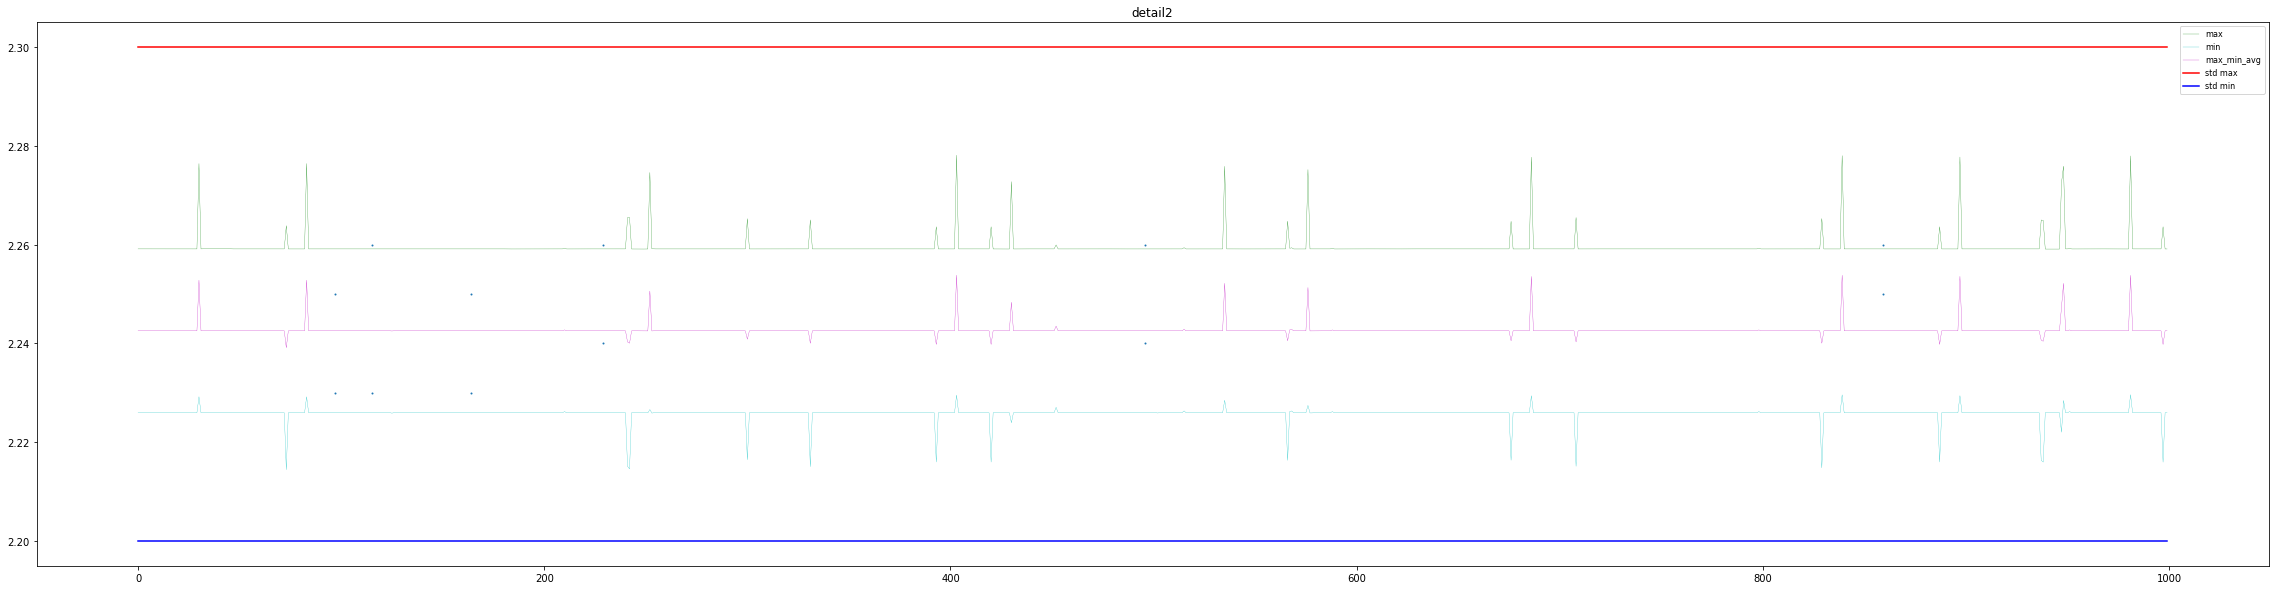

detail3


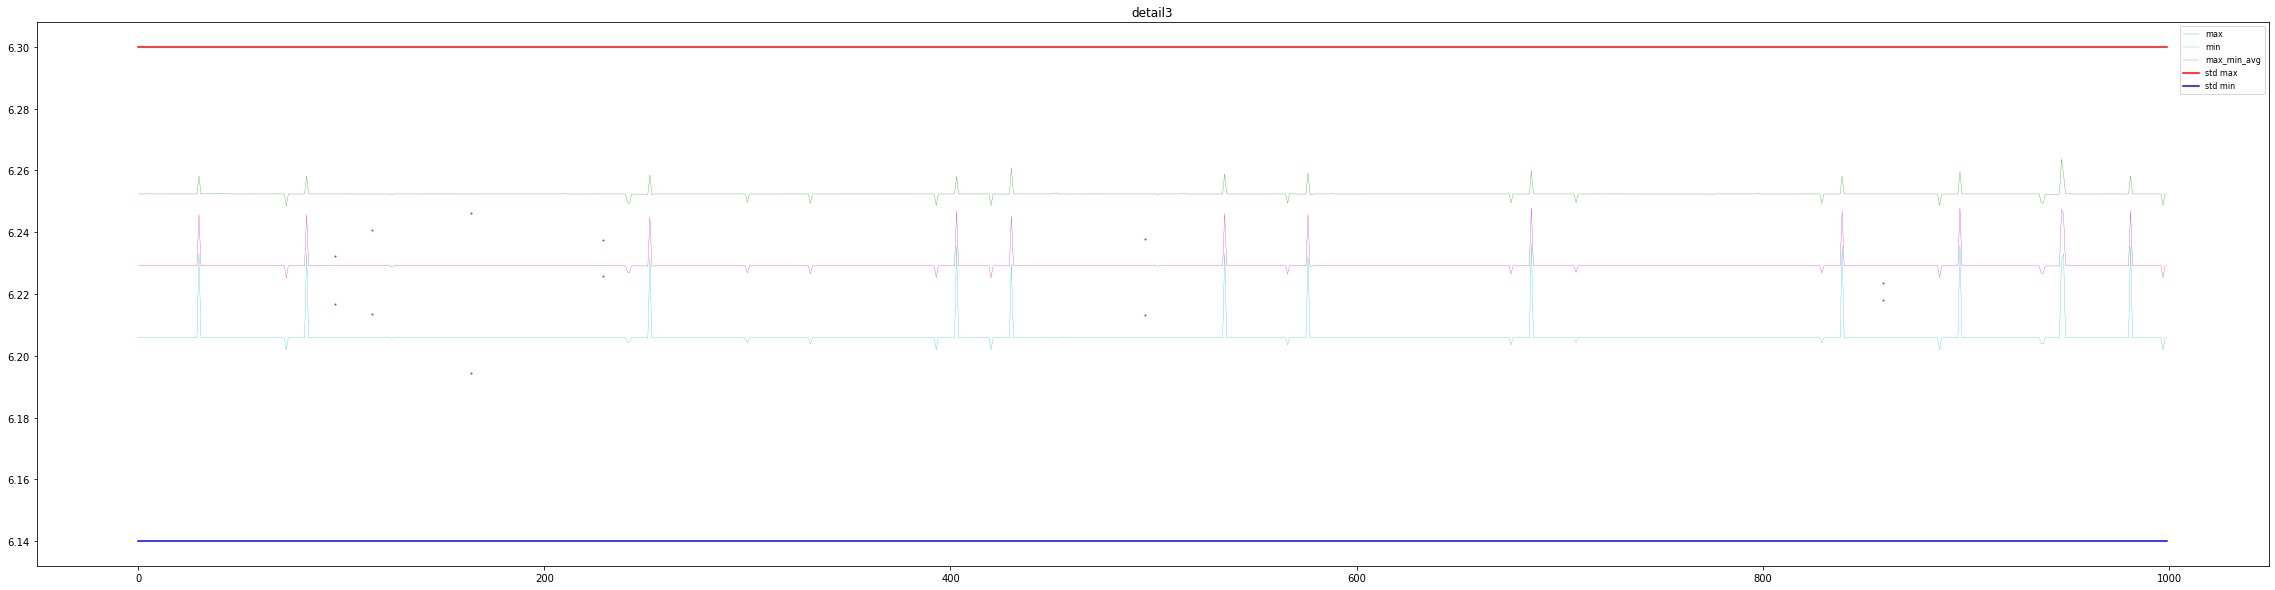

detail4


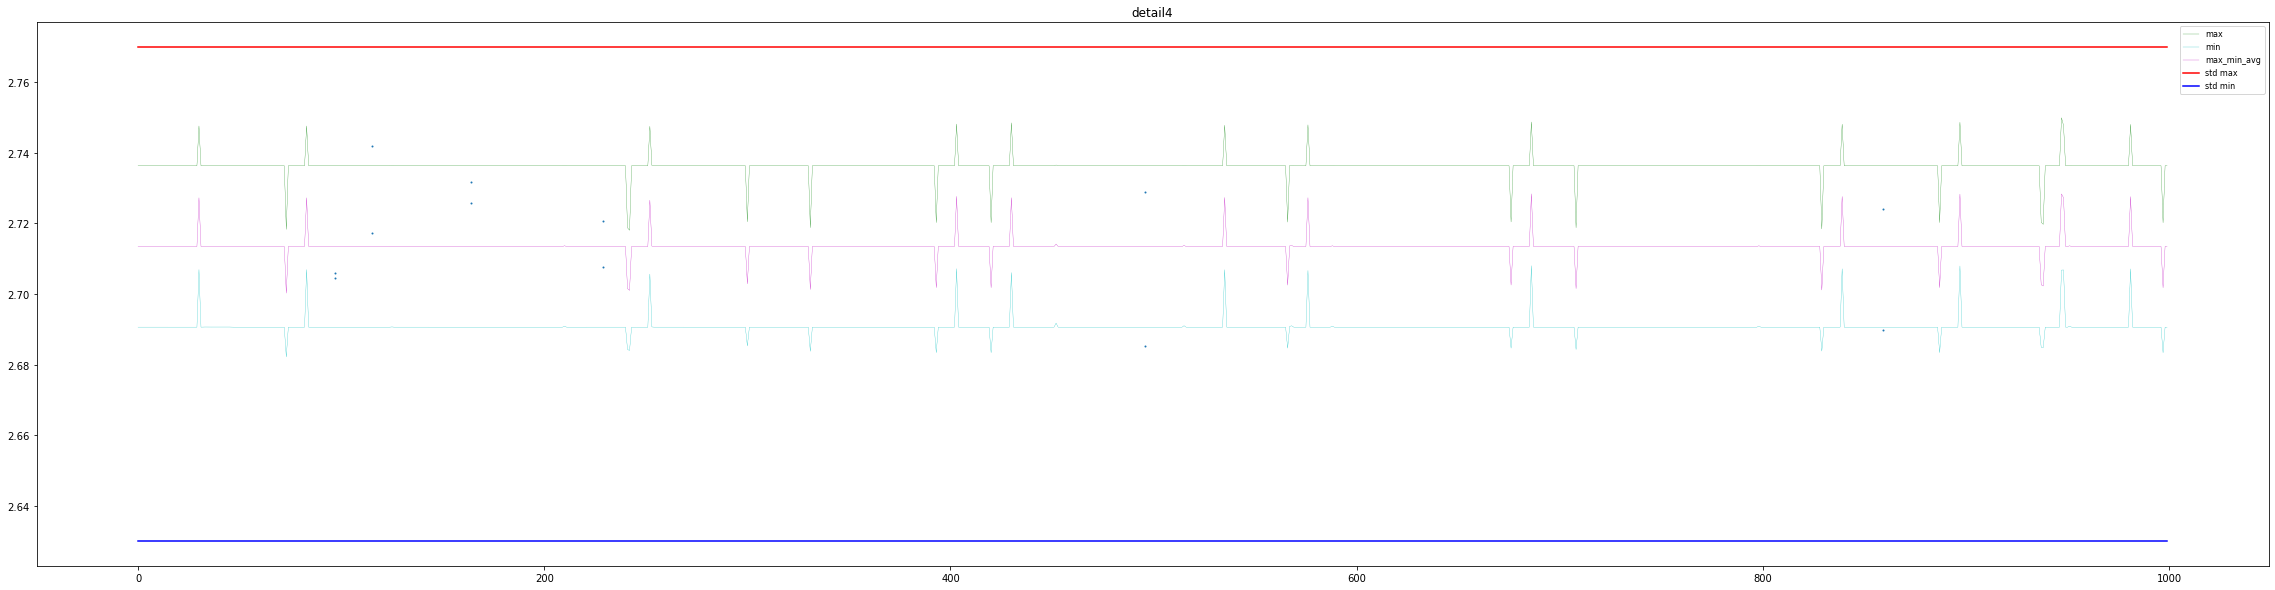

detail5


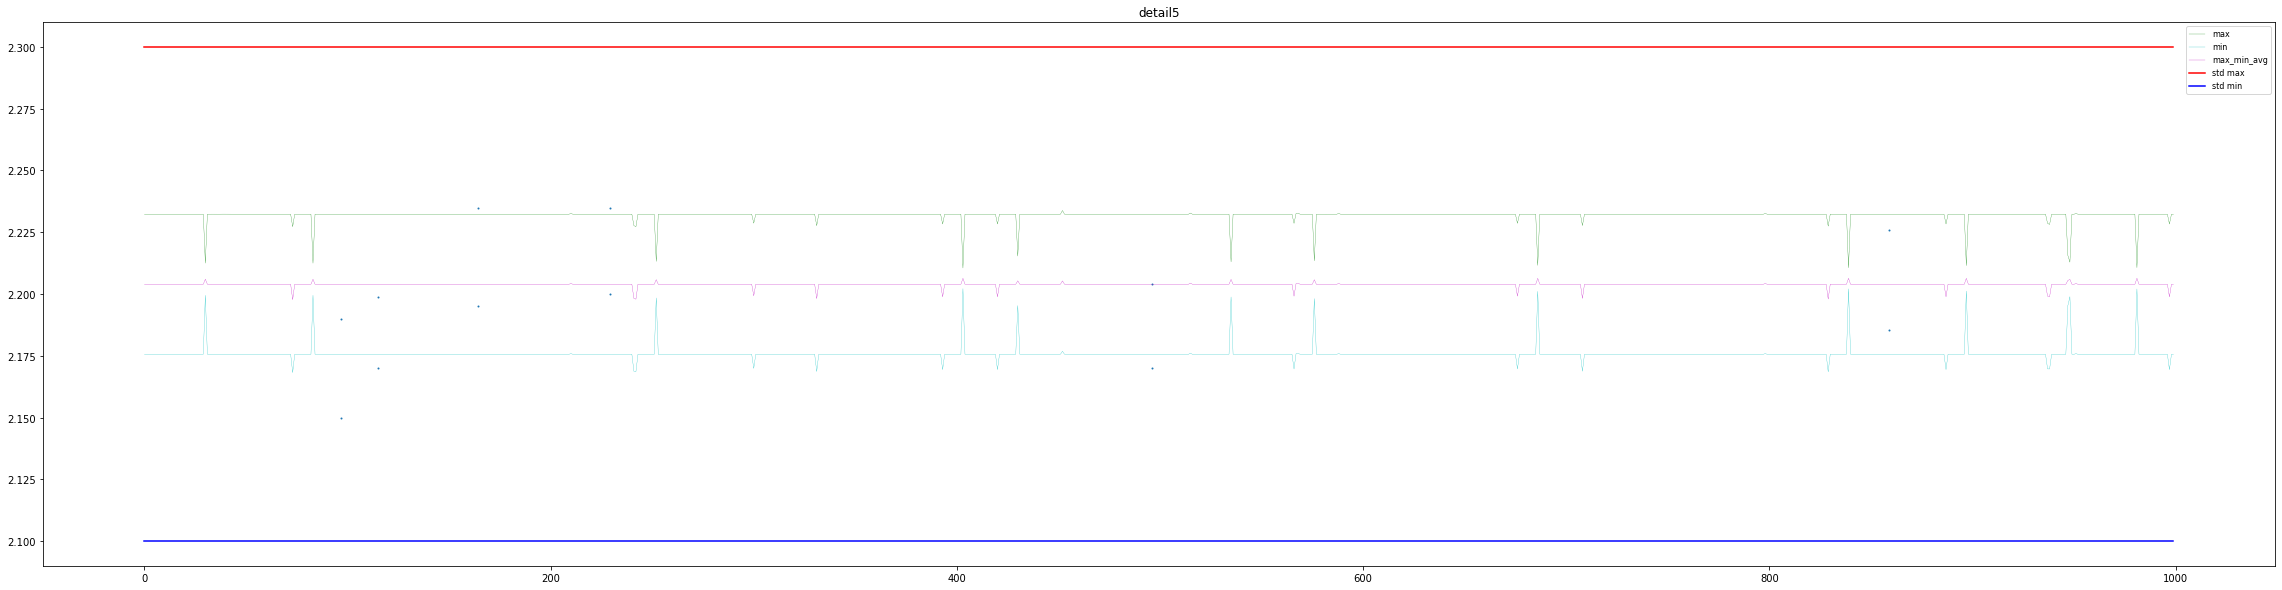

detail6


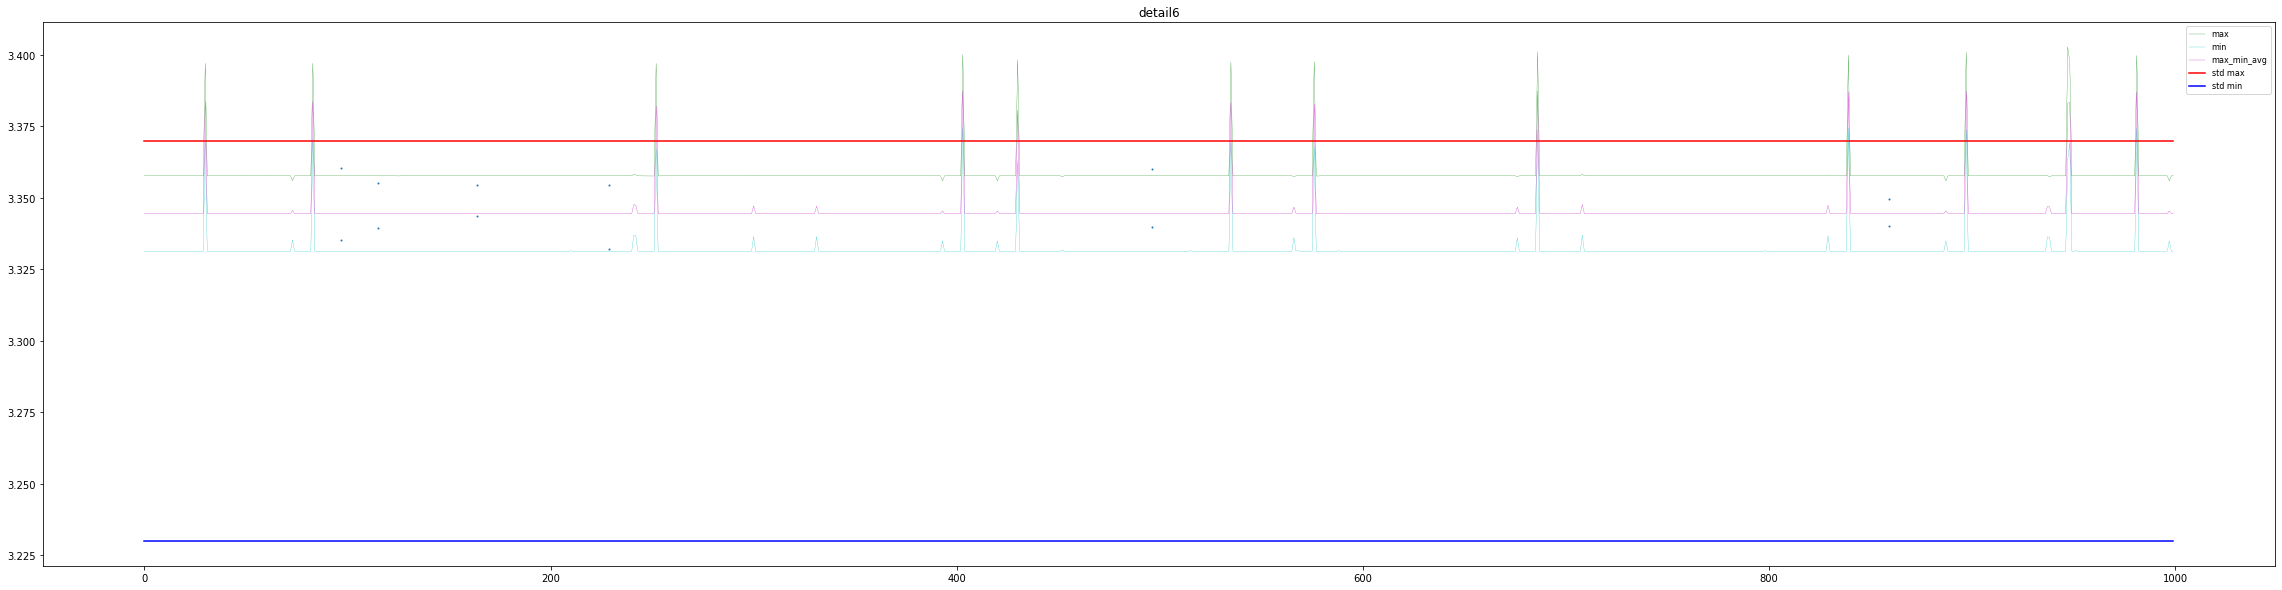

detail7


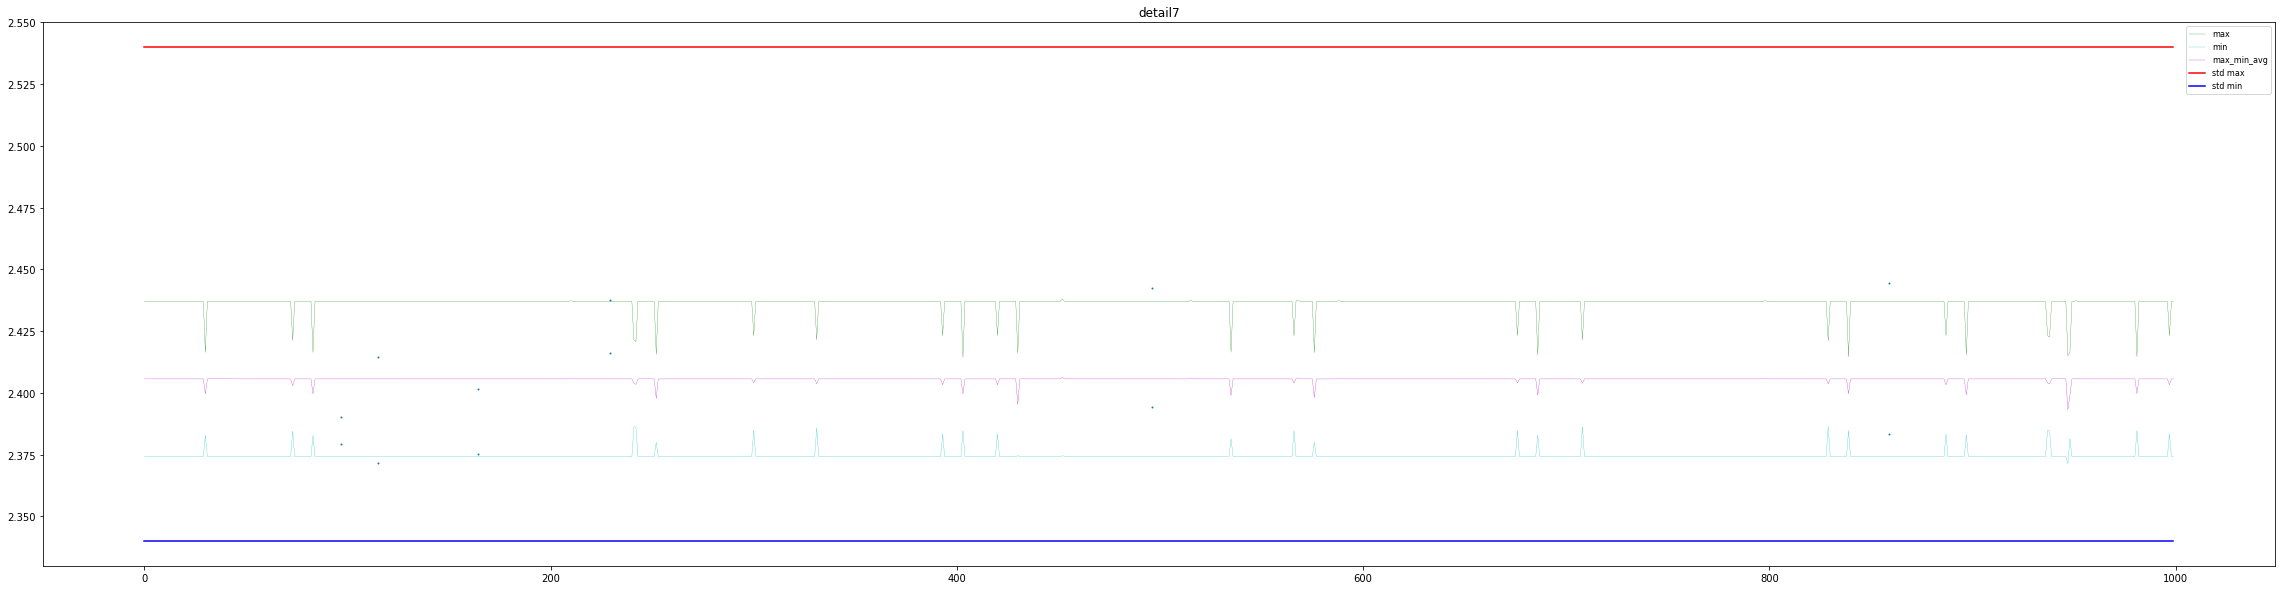

detail8


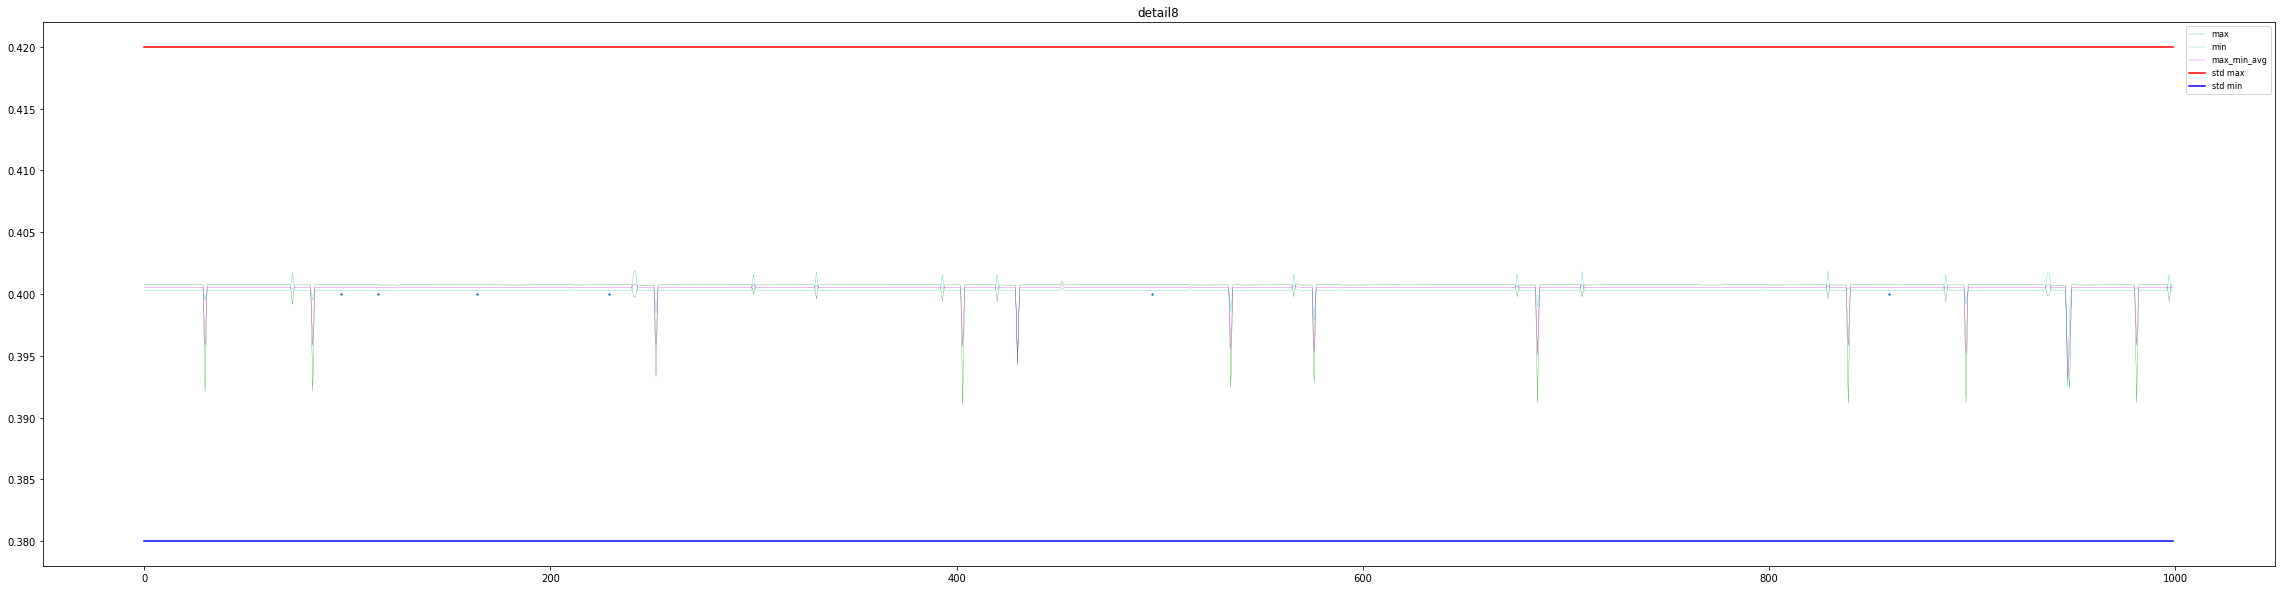

detail9


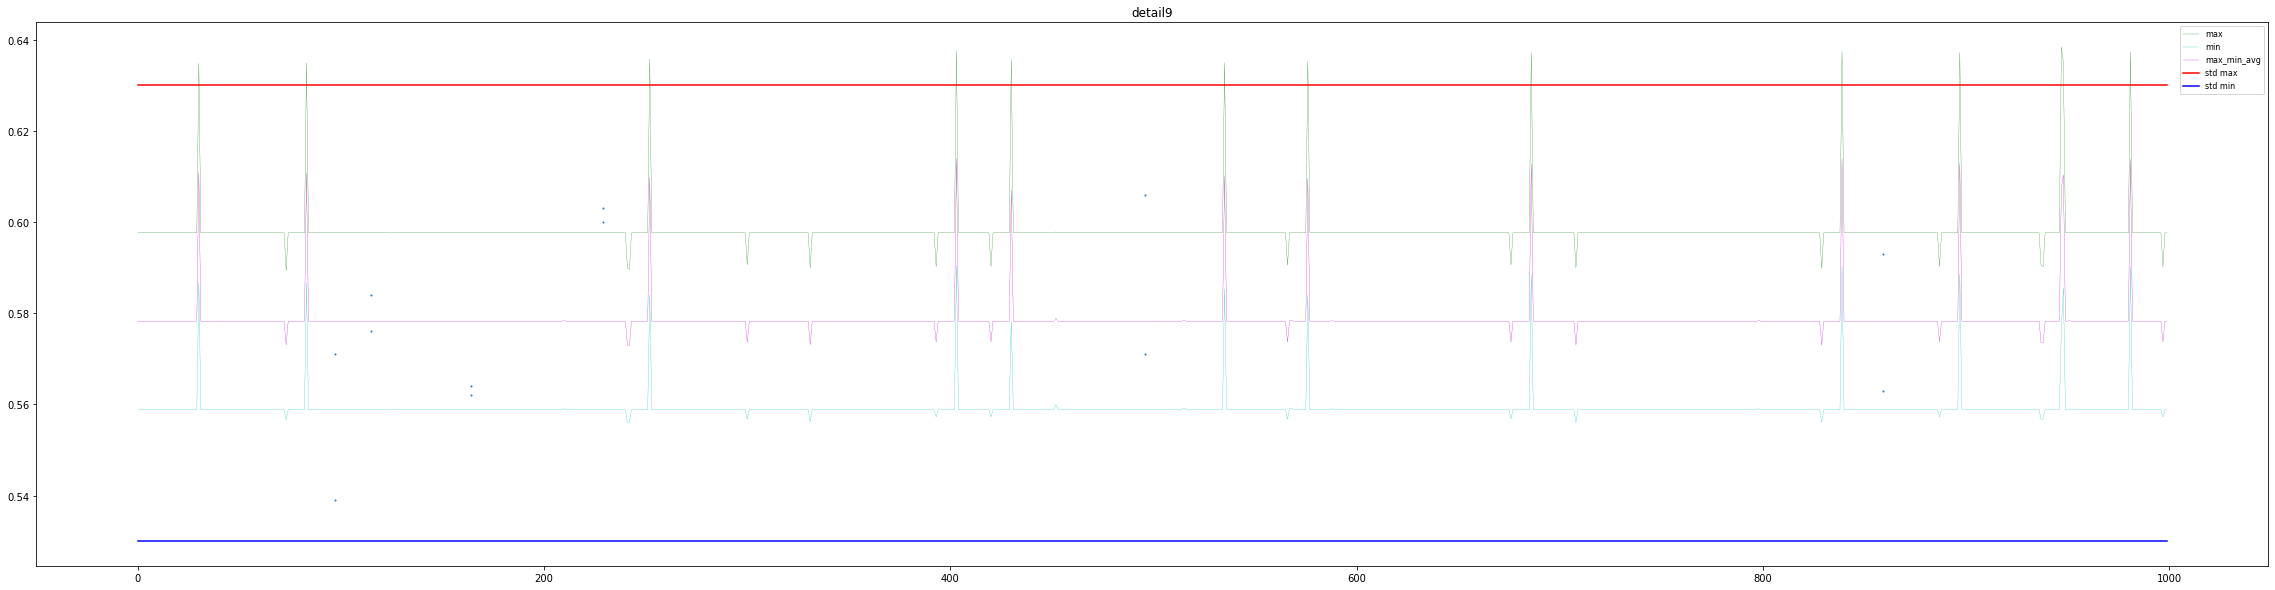

detail10


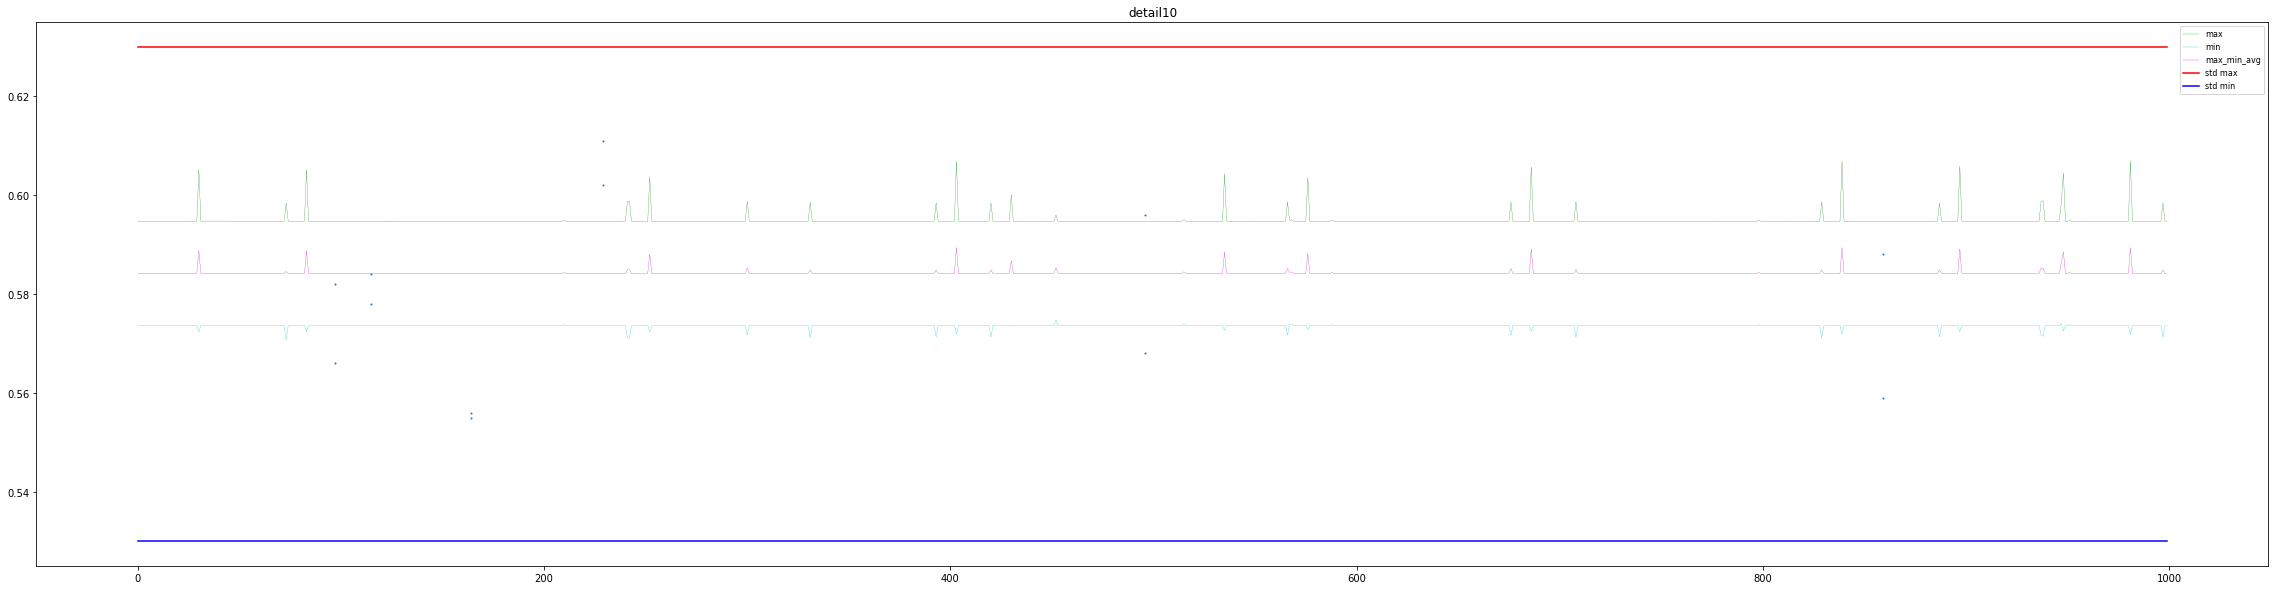

detail11


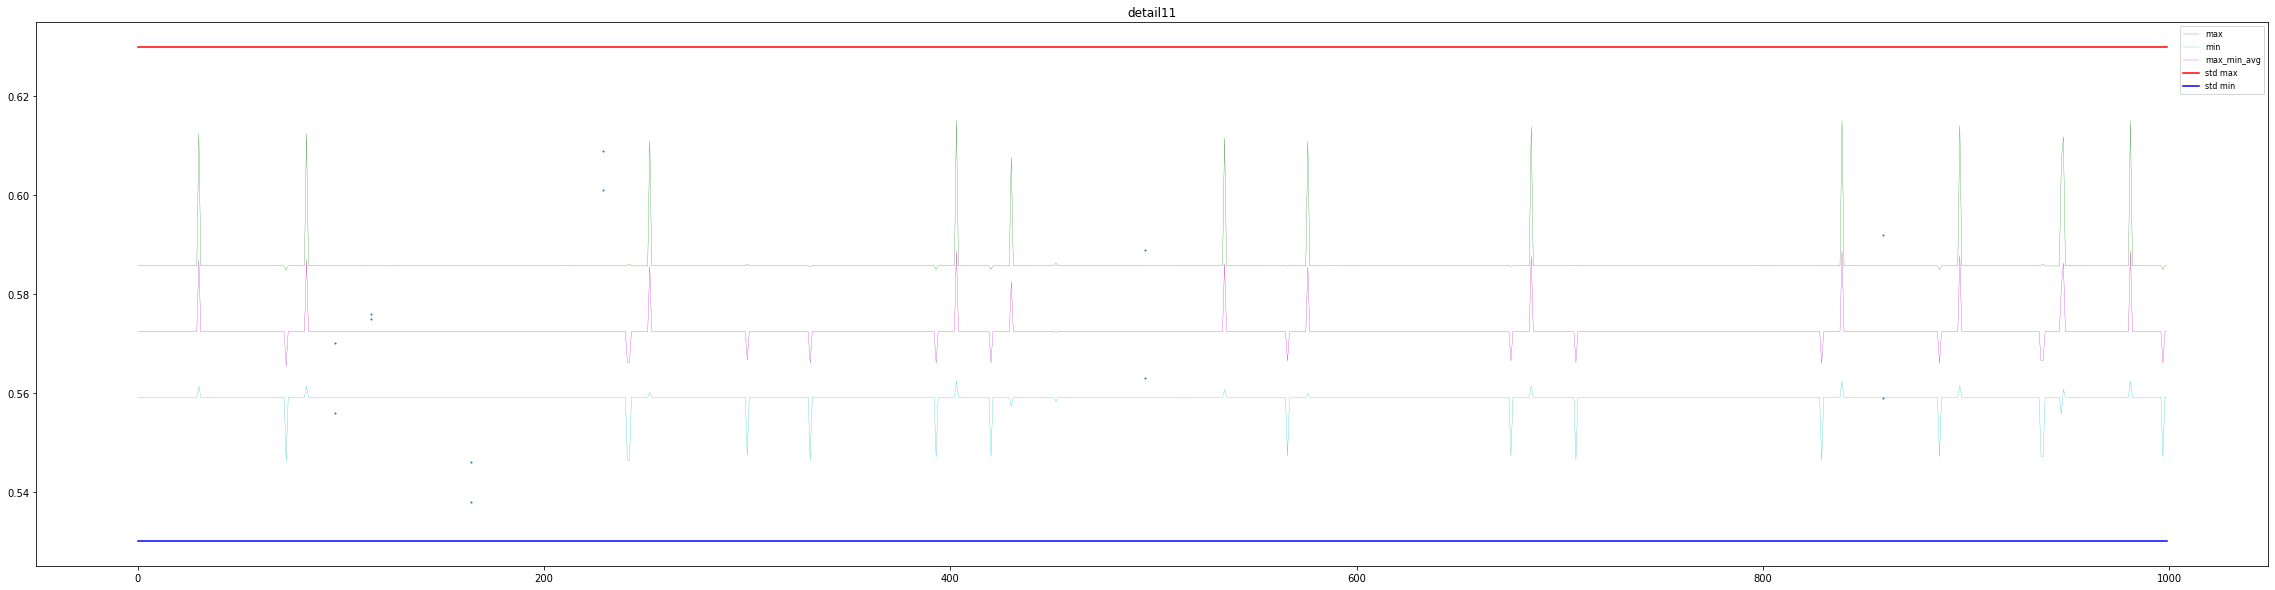

detail12


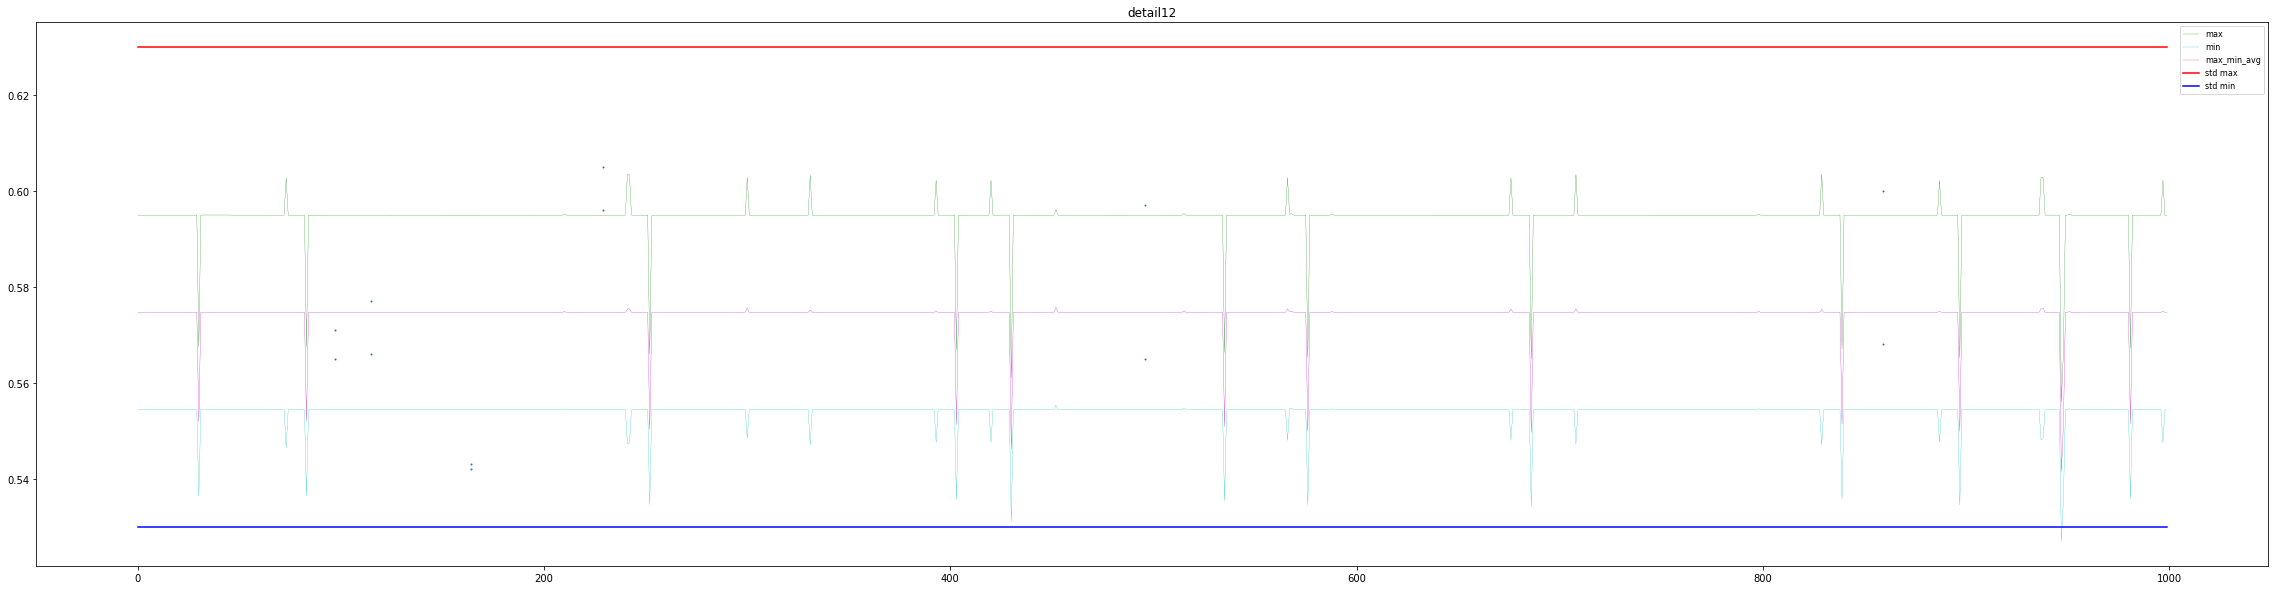

detail13


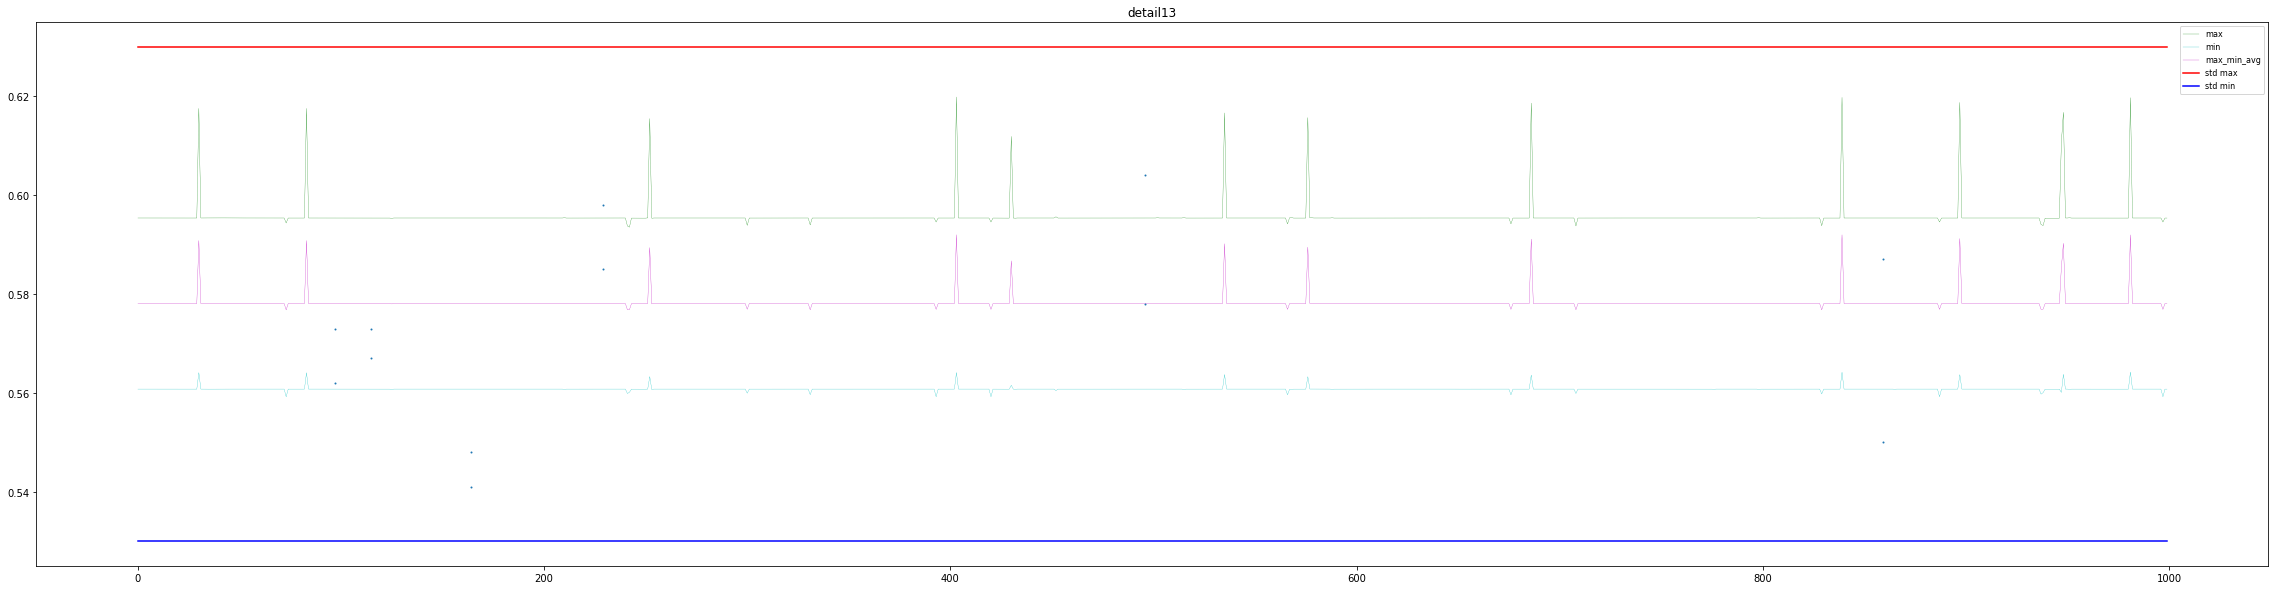

detail1


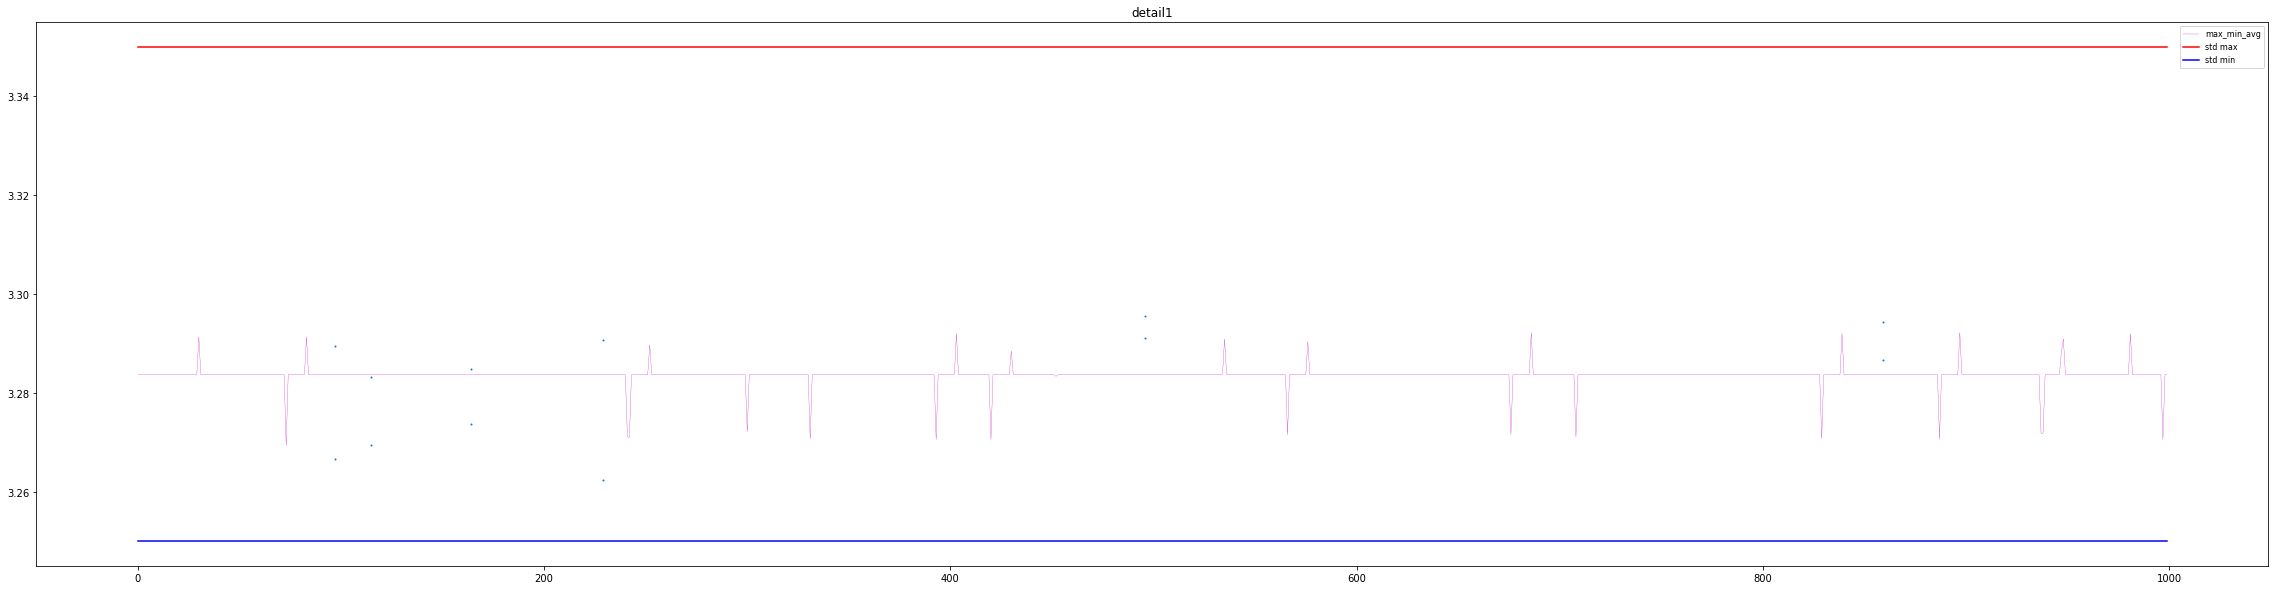

detail2


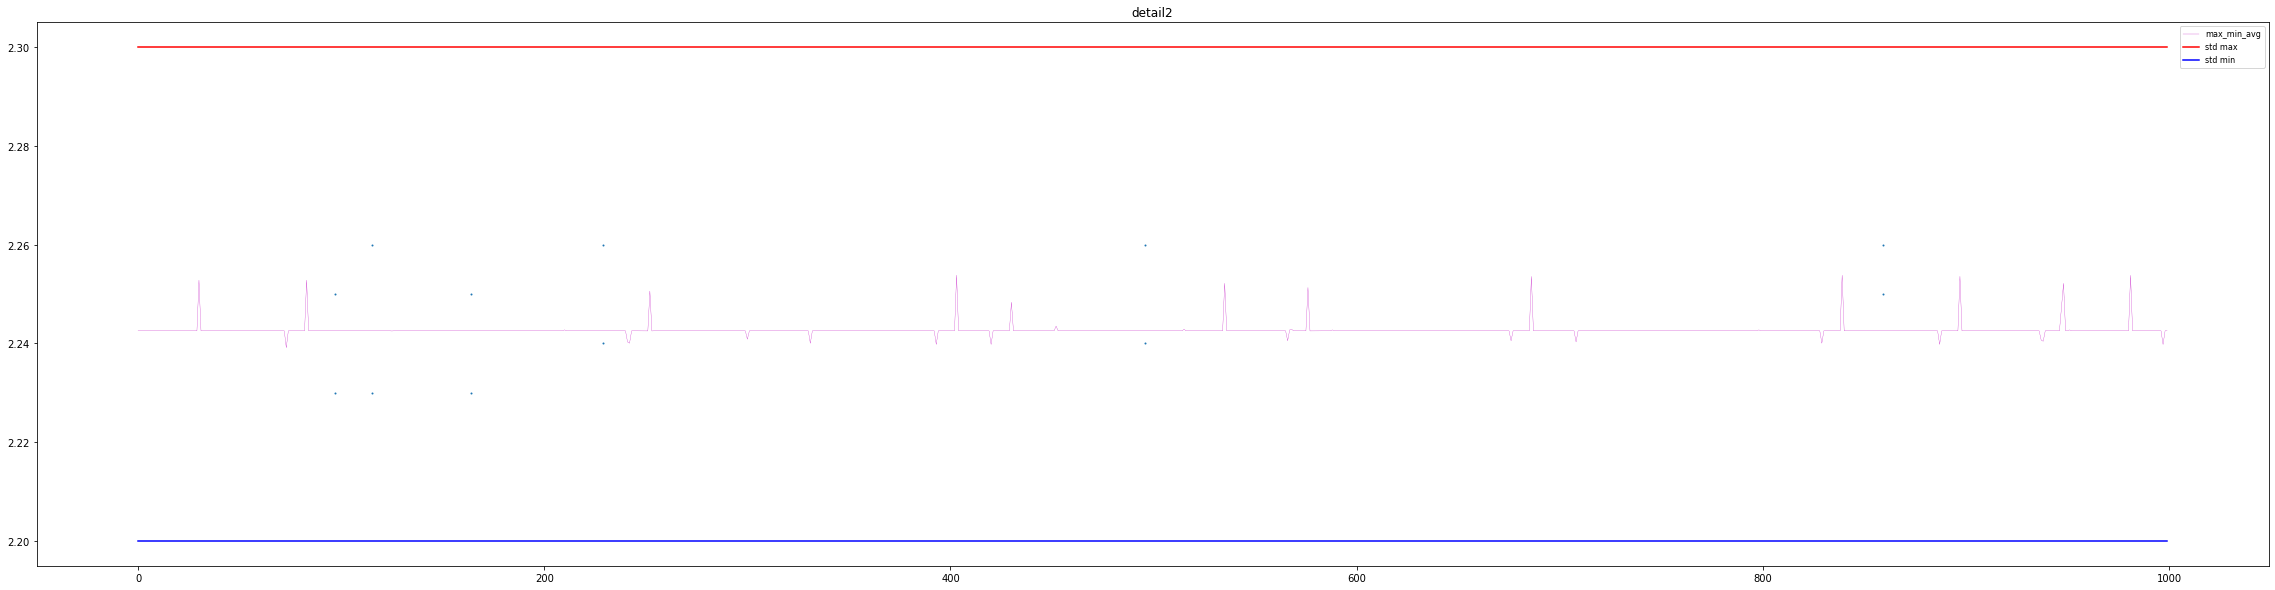

detail3


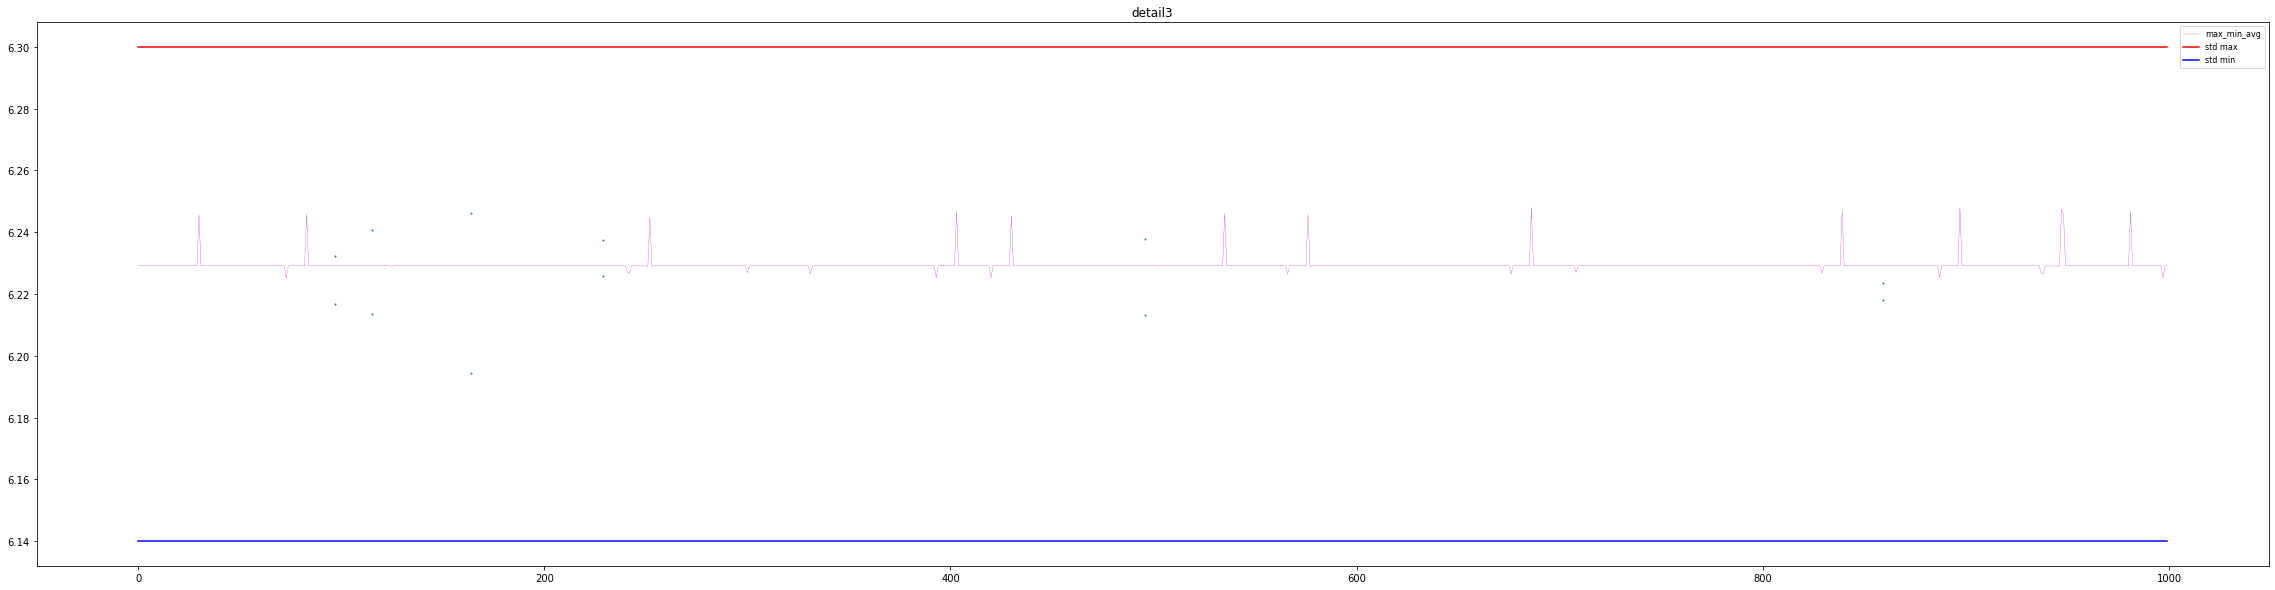

detail4


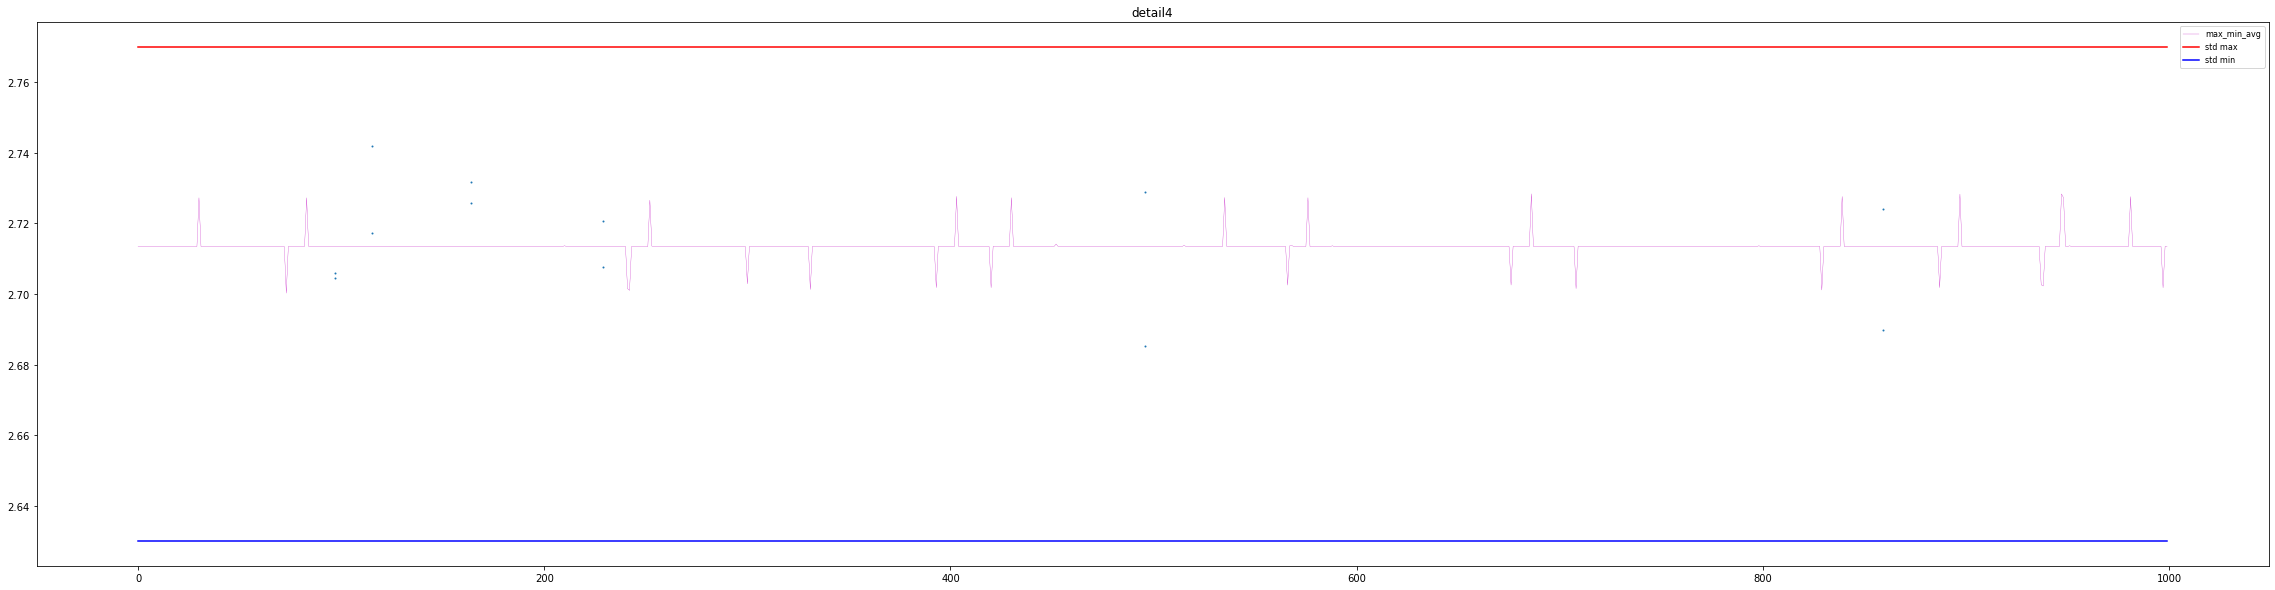

detail5


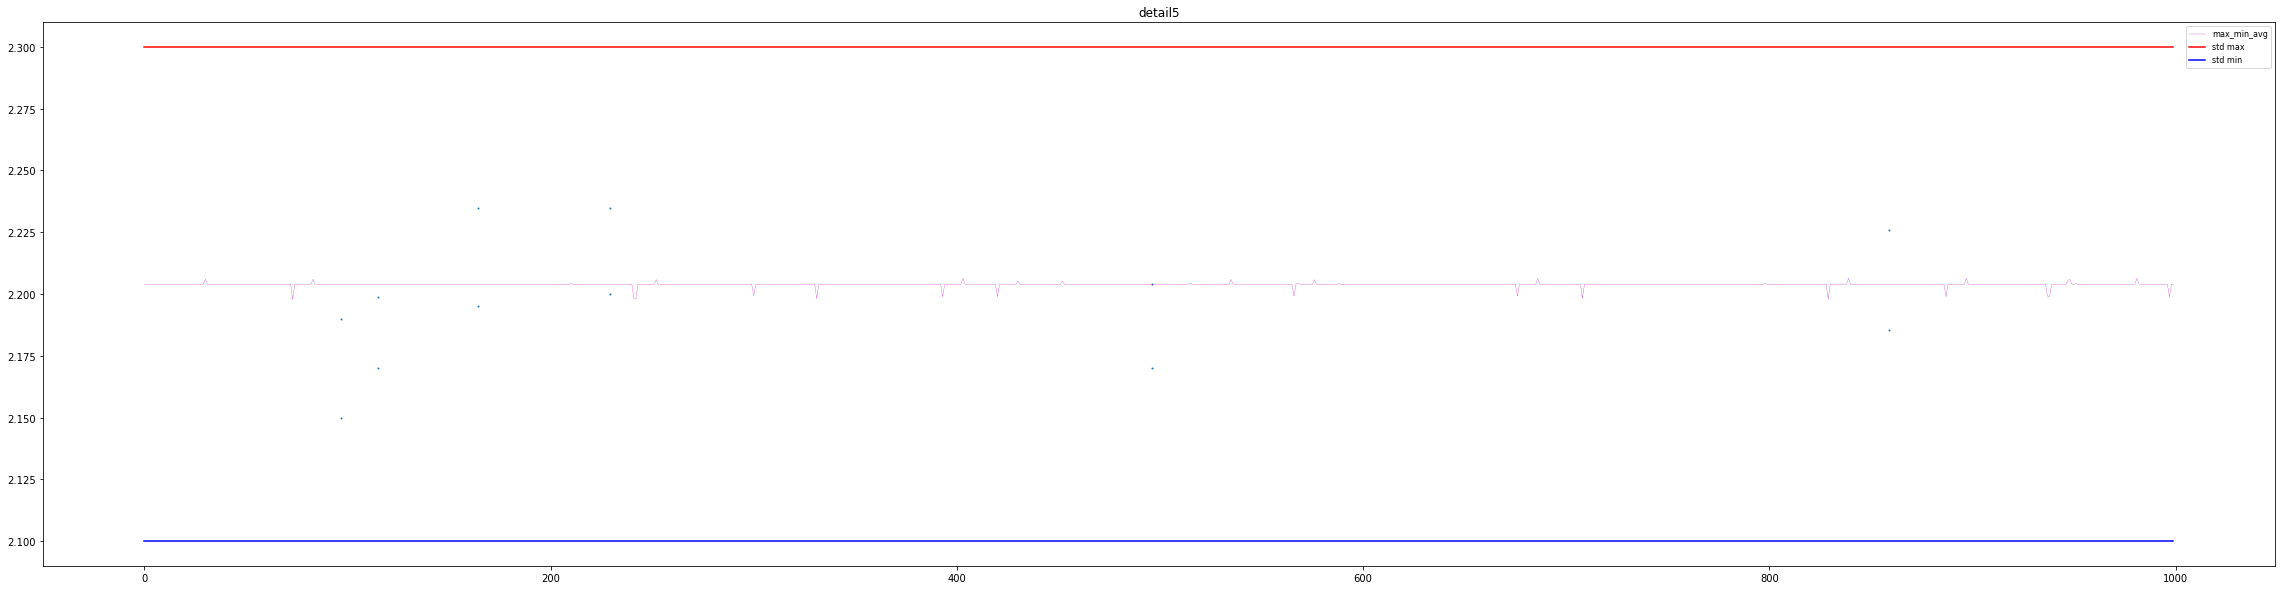

detail6


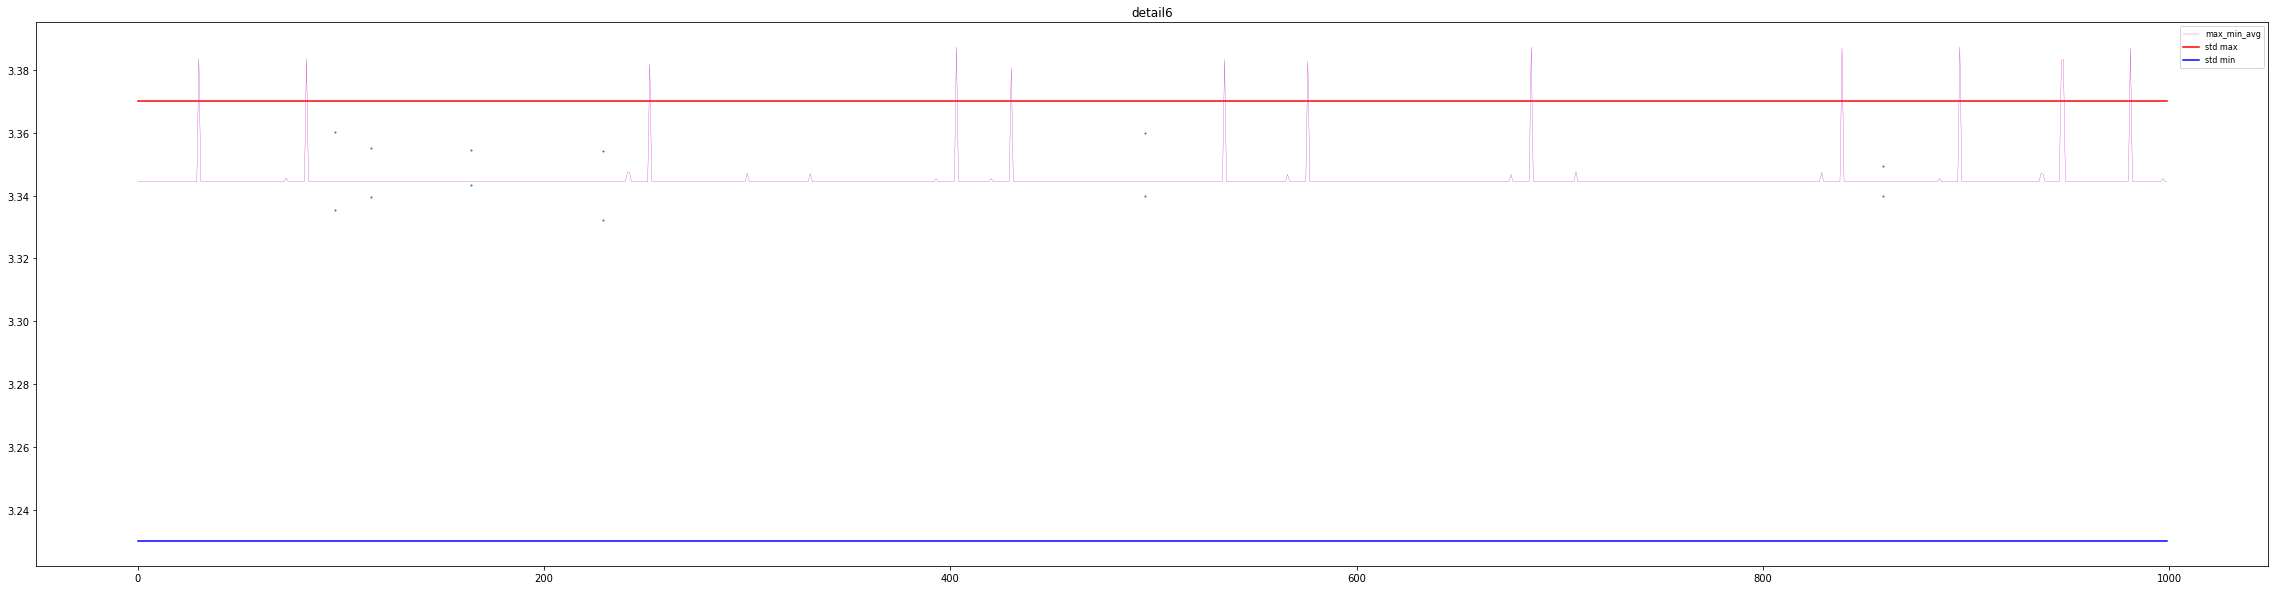

detail7


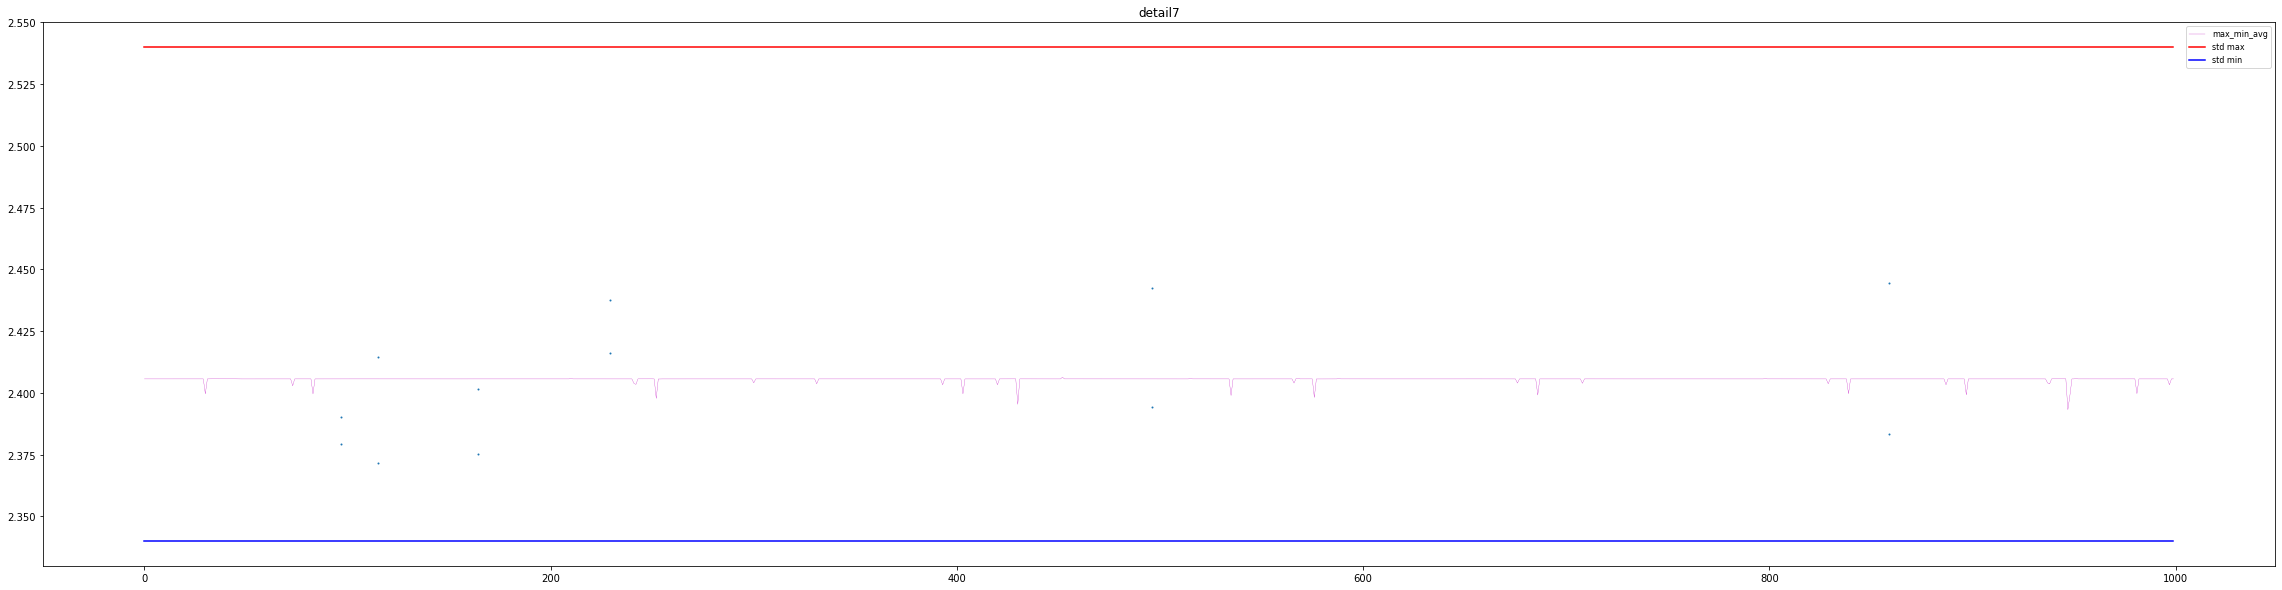

detail8


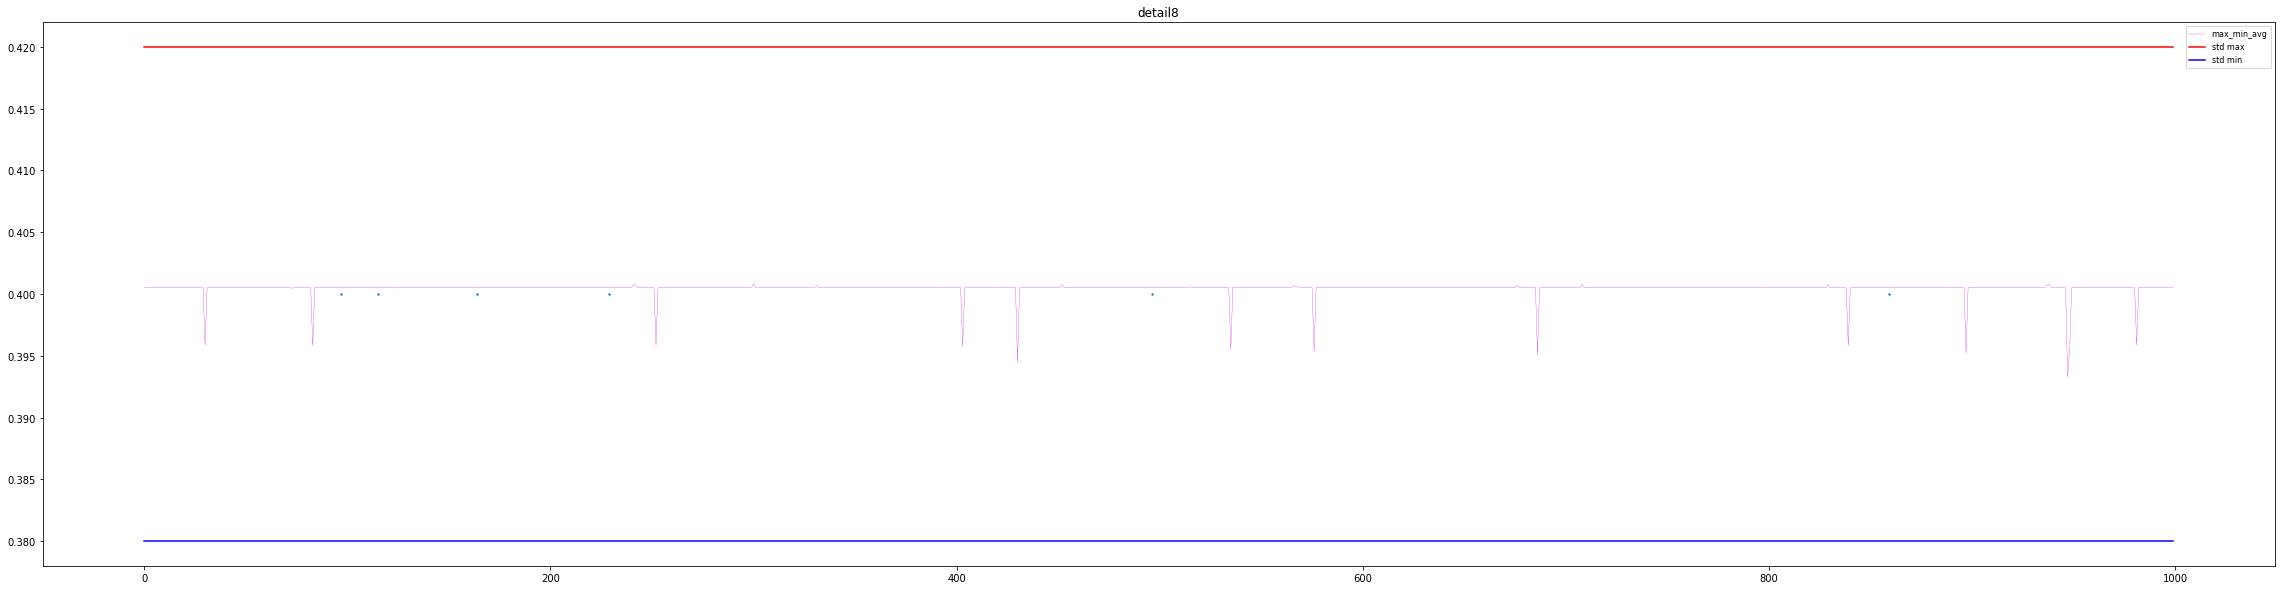

detail9


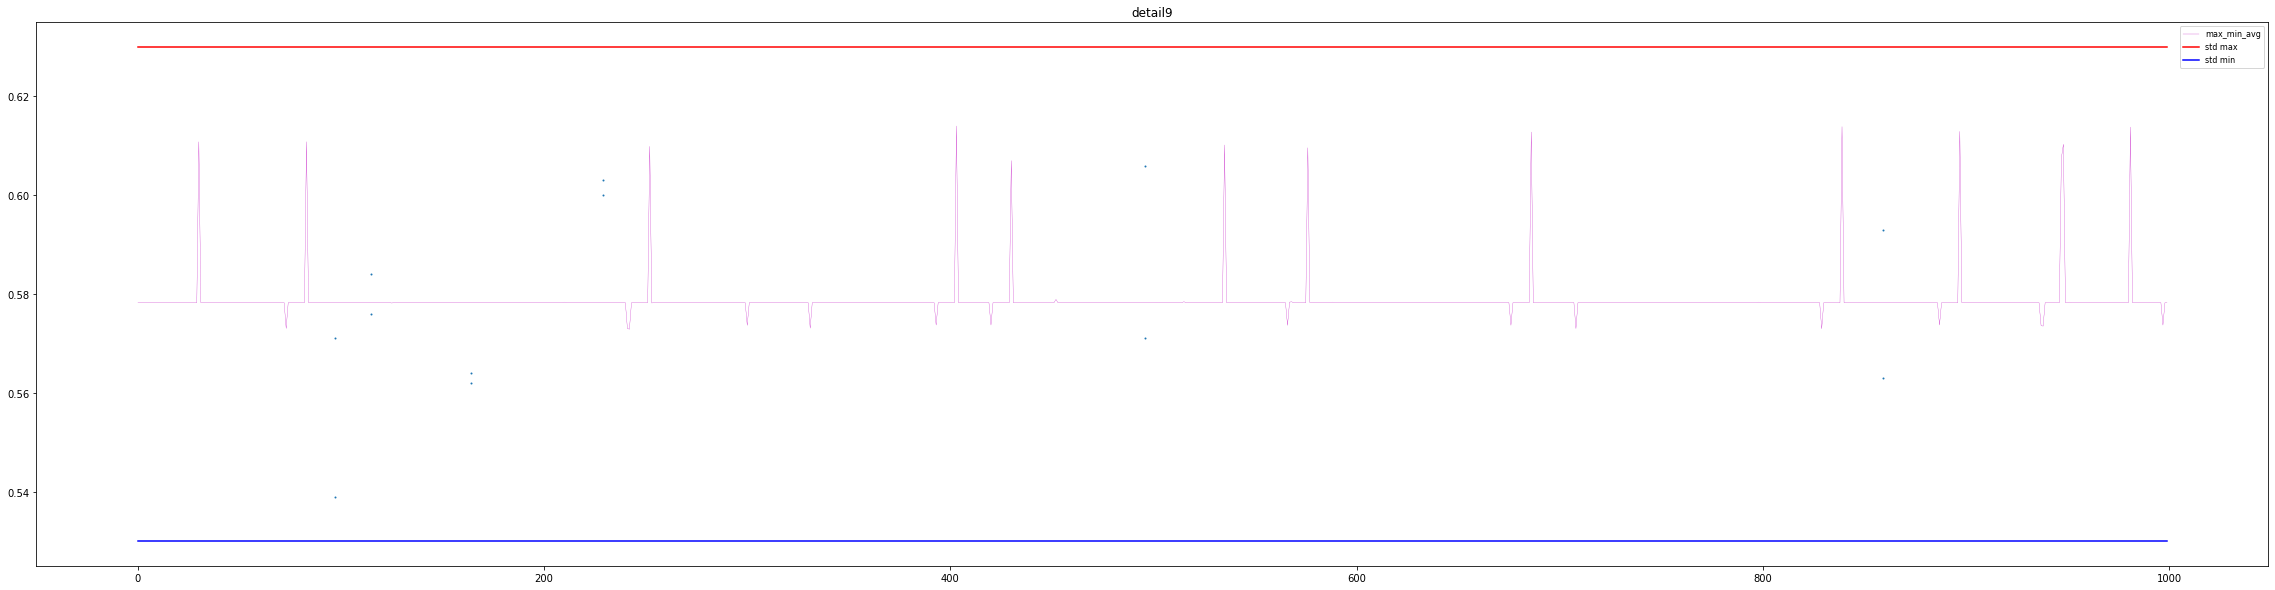

detail10


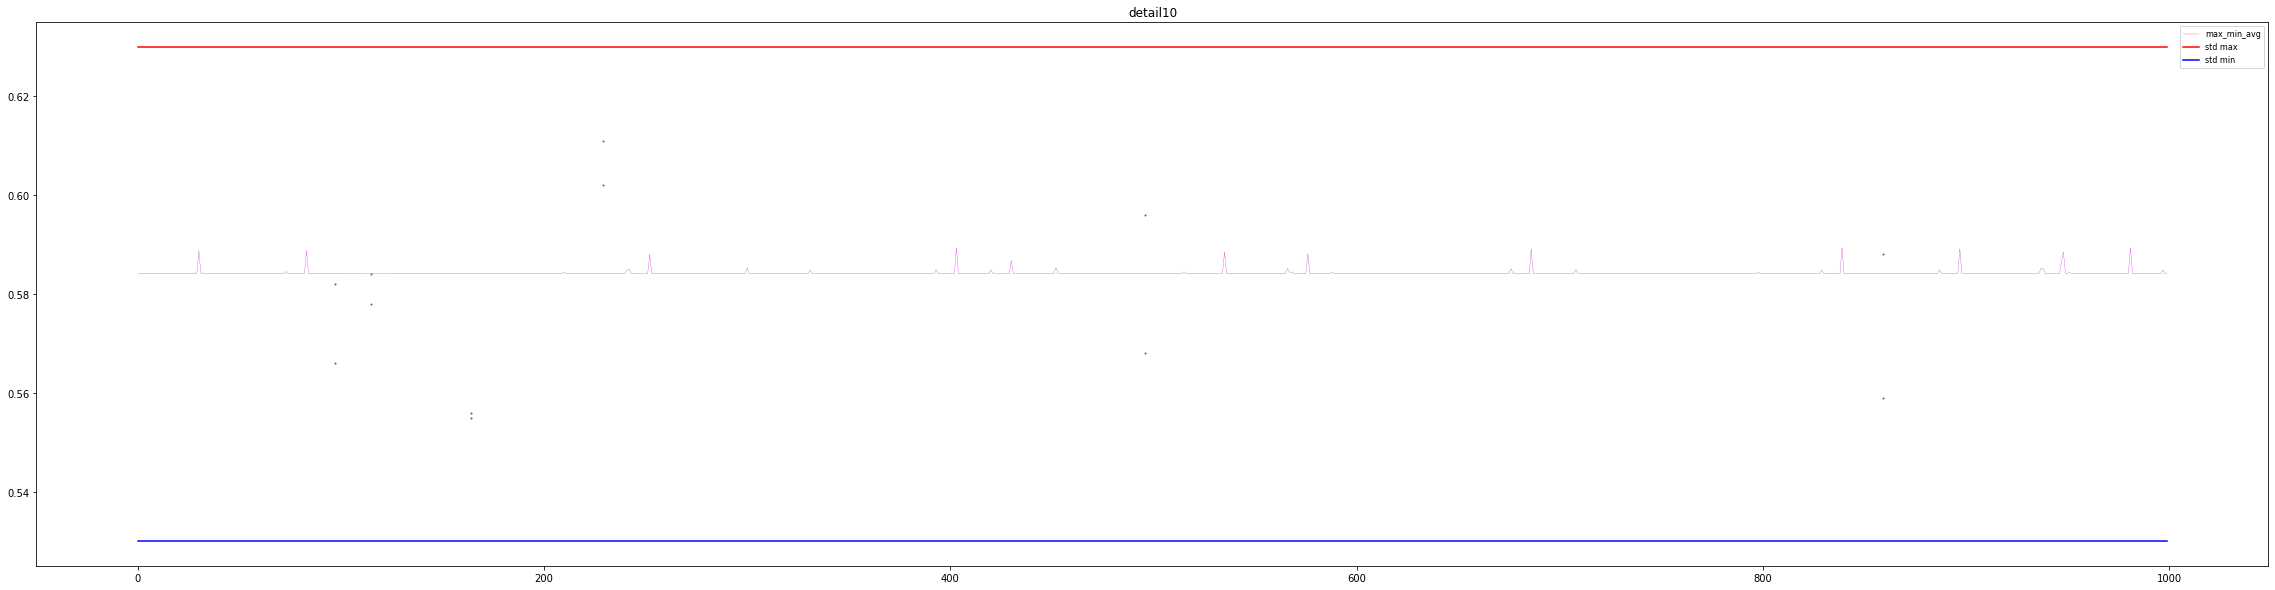

detail11


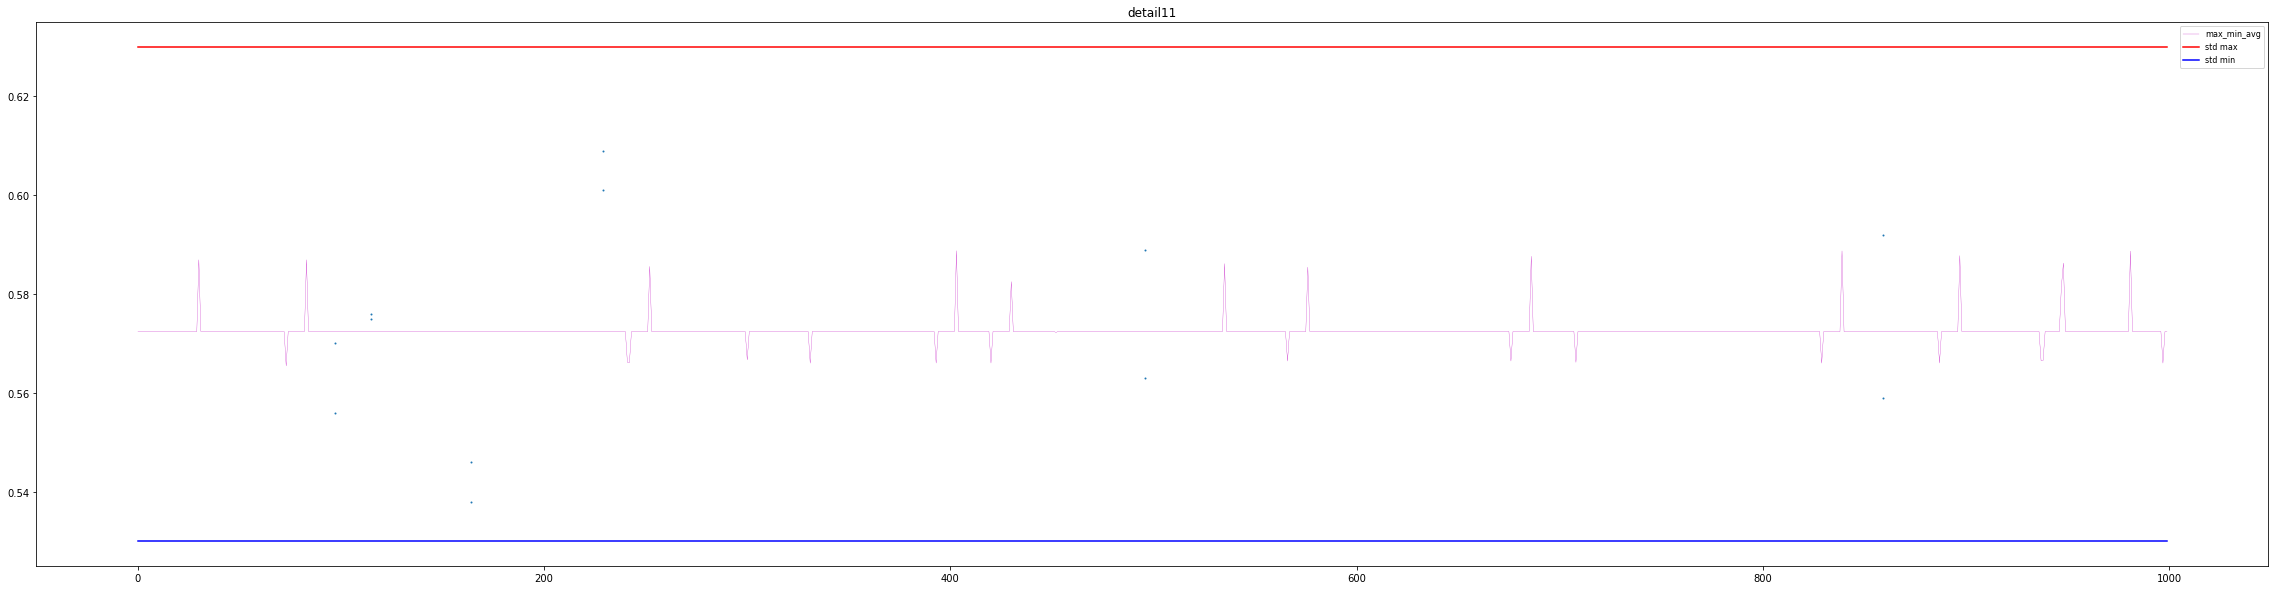

detail12


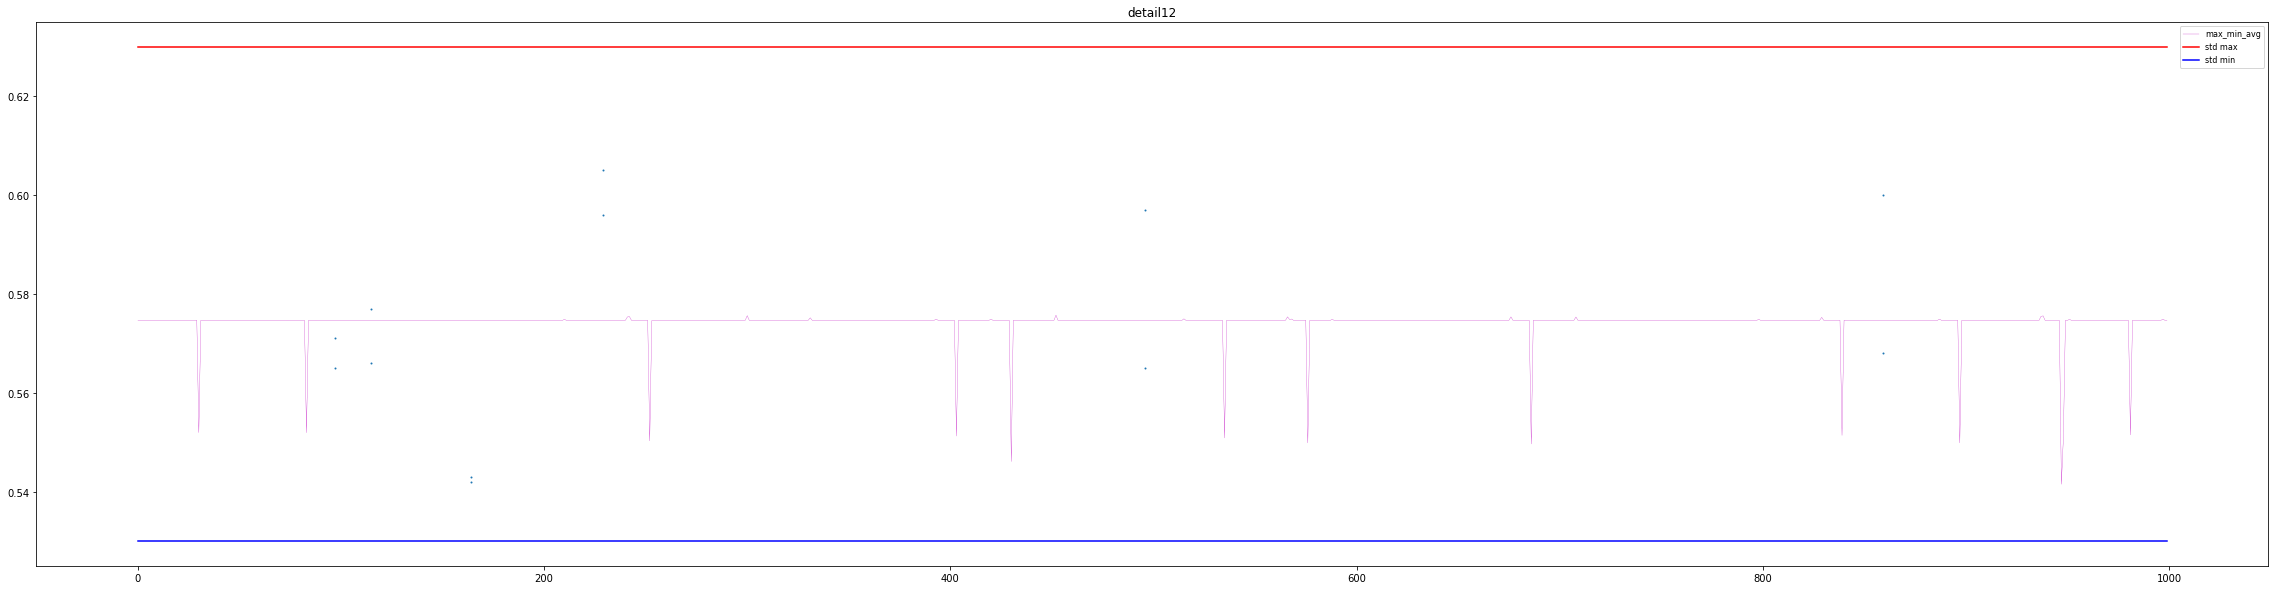

detail13


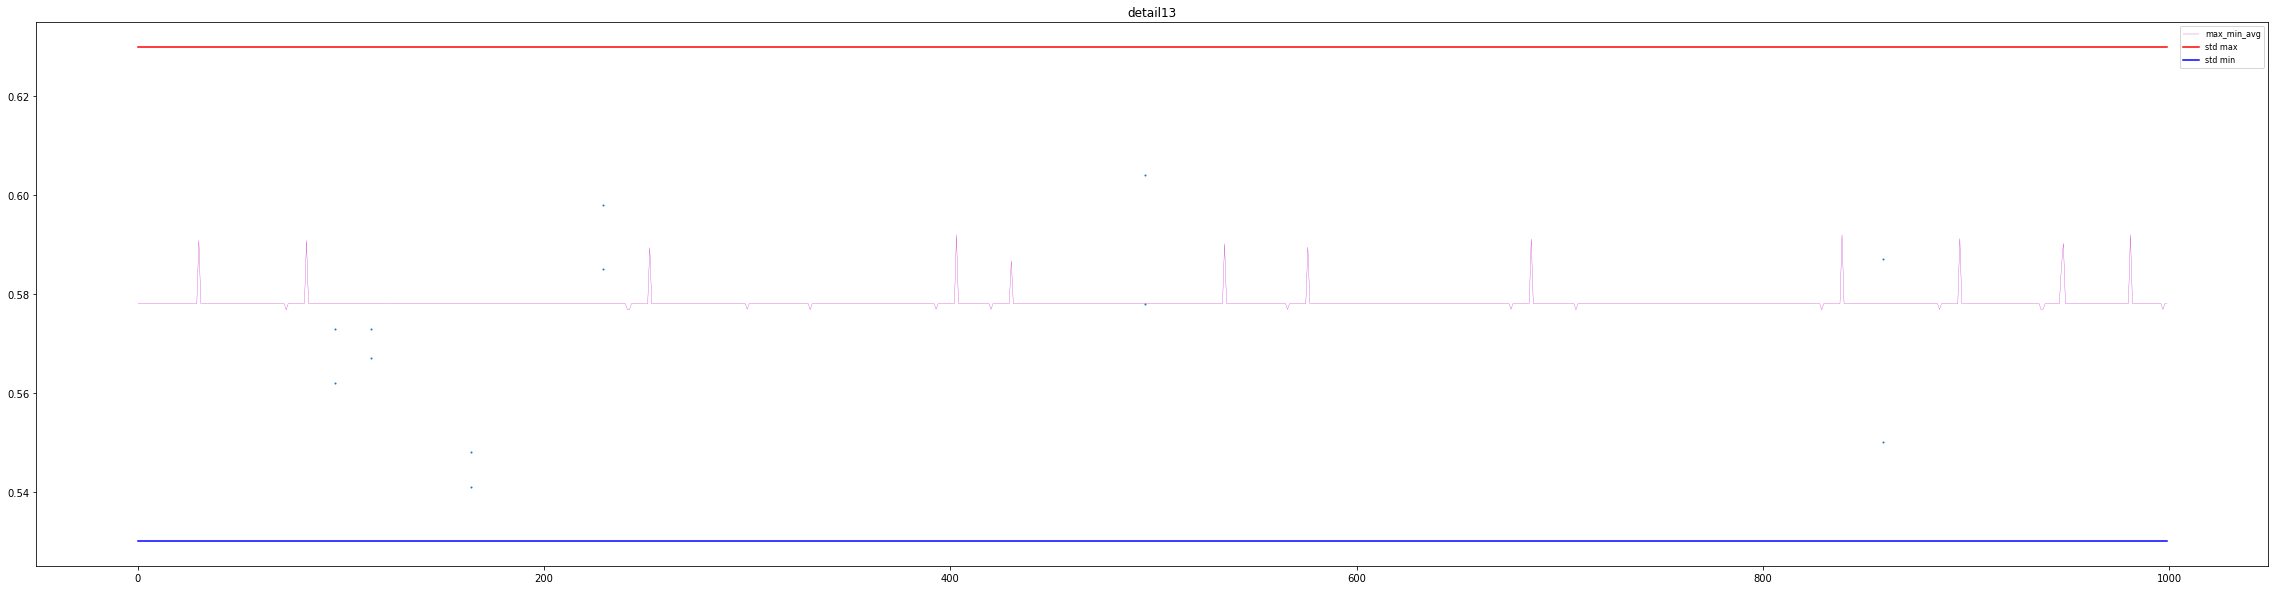

In [ ]:
rate(df)

labels = []
pred_label(by_package, by_machine)

pred_detail_plot(partNo,by_package, by_machine)
pred_avg_plot(partNo,by_package, by_machine)

#Analysis
##Error distribution histogram

In [ ]:
# put prediction output file path, ex: 'pred_all.npy'
pred = np.load(folder_path+'pred.npy')
pred = pd.DataFrame(pred)
print(pred.shape) #(data_num, output_num)

(1000, 26)


In [ ]:
"""
Error distribution histogram for prediction
"""
def detail_wrong_pic_pred(detail_max, detail_min):
  plt.figure(figsize=(12,4))
  labels=[]

  for i in range(1,14):
    labels.append("detail"+str(i))

  x = np.arange(1,14)
  width = 0.25

  plt.bar(x - width/2, detail_max, color="steelblue",label="pred > std(max)",width= 0.25)
  plt.bar(x + width/2, detail_min, color="darkgrey",label="pred < std(min)",width= 0.25)
  plt.xticks(range(1,14))
  plt.legend(loc='upper left')
  # plt.savefig(folder_path+'detail_wrong.jpg')
  plt.show()

In [ ]:
"""
規格判斷 for prediction
data為預測資料, partNo為料號編號
"""
def measure_std_pred(data, partNo):
  measure = []
  
  for data_num in range(len(data)):
    partNo = partNo
    if partNo == "0162B00100":
      max_std = [3.35, 2.30, 6.30, 2.77, 2.30, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B00200":
      max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B00200-1":
      max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
      min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

    elif partNo == "0162B01100":
      max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B01100-1":
      max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
      min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

    else:
      return "Error"

    for detail_num in range(13):
      if data[detail_num][data_num] > max_std[detail_num]: 
        detail_max_wrong[detail_num] += 1
      if data[detail_num+13][data_num] < min_std[detail_num]:
        detail_min_wrong[detail_num] += 1

  return measure

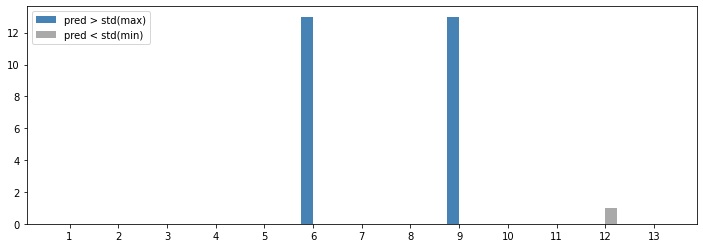

In [ ]:
"""
Execute example
"""
detail_max_wrong = np.zeros(13)
detail_min_wrong = np.zeros(13)

measure_std_pred(pred, partNo)
detail_wrong_pic_pred(detail_max_wrong, detail_min_wrong)